 
|Variable|Description|
|:-------|:--------|
|dswrf_sfc_wm2 | Net downward shortwave radiation flux|
|gust_sfc_ms | Wind gust surface (Böe)|
|hpbl_sfc_m | Planetary boundary layer height|
|msl_ms_pa | Mean sea level pressure|
|pottemp_80mto0m_K | Potential temperature difference between 80m and 0m|
|q_2m_1 | Specific humudity in 2 m height|
|q_pfg30_1 | Specific humidity mean over first 30 hPa (~250m)|
|r_pl925_% | Relative humidity in 925 hPa pressure level|
|r_pl950_% | Relative humidity in 950 hPa pressure level |
|shtfl_sfc_wm2 | Net sensible heat flux (conductive heat flux from the Earth's surface to the atmosphere)|
|t_100m_k | Temperature in 100 m height in Kelvin|
|t_2m_k | Temperature in 2 m height in Kelvin|
|t_pfg30_k | Temperature mean ober first 30 hPa (~250m) in Kelvin |
|tcclow_sfc_% | Total Cloud Cover, low level clouds (0km - 2km height)|
|tccmedium_sfc_% | Total Cloud Cover, medium level clouds (2km - 7km height)|
|wdir_100m_dn | wind direction in 100 m height in in degrees|
|wdir_10m_dn | wind direction in 10 m height in in degrees|
|wdir_pfg30_dn | wind direction mean over first 30 hPa (~250m) in degrees|
|wdir_pl925_dn | wind direction in 925 hPa pressure level in degrees|
|wsp_100m_ms | wind speed in 100 m height in meters/second|
|wsp_10m_ms | wind speed in 10 m height in meters/second |
|wsp_pfg30_ms | wind speed mean over first 30 hPa (~250m) in meters/second|
|wsp_pl925_ms | wind speed in 925 hPa pressure leben in meters/second|
|created_on | date and 24 hours divided in quarters|
|azimuth | shows the rotation of the wind turbine|
|elevation | heights of the sun|

In [1]:
reset -fs

# Loading Modules and Datasets

In [40]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns
import numpy as np

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from scipy.stats import uniform
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, cross_validate
from sklearn import preprocessing
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, explained_variance_score

import xgboost as xgb
from xgboost import XGBRegressor
import urllib.request
import json
import time
from datetime import datetime
import requests
from fbprophet import Prophet
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.ar_model import AR
from random import random

import plotly as py
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

%matplotlib inline

In [3]:
# reading in the first dataframe
with open('griddata_gfs_us_20180101_20190826_03_final.p', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    df_fin = u.load()

In [4]:
# rename columns which contains symbols
df_fin = df_fin.rename(columns={'r_pl925_%': 'r_pl925_perc','r_pl950_%': 'r_pl950_perc',
                        'tcclow_sfc_%': 'tcclow_sfc_perc','tccmedium_sfc_%': 'tccmedium_sfc_perc'})
# converting to actual timezone
df_fin.index = df_fin.index.tz_localize(None).to_series(keep_tz=True)

# resampling to a time range of 15 minutes and interpolate between the hourly values
df_fin = df_fin.resample('10min', axis='index').interpolate()
df_fin = df_fin.fillna(method='ffill')

# creating columns with name of the day and month
df_fin['day_name'] = df_fin.index.day_name()
df_fin['day_name'] = df_fin['day_name'].astype('category')
df_fin['month_name'] = df_fin.index.month_name()
df_fin['month_name'] = df_fin['month_name'].astype('category')

In [5]:
# reading in the second dataframe
with open('obs_20180101_20190625_03_final_normed.p', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    df_norm = u.load()


In [6]:
# converting to the same timezone as the first dataframe
df_norm.index = df_norm.index.tz_localize(None).to_series(keep_tz=True)

# resample 
# df_norm = df_norm.resample('H').mean()

In [7]:
# combining both dataframes to have one to work in
df = pd.concat([df_norm,df_fin], axis=1)

In [8]:
df.columns

Index(['power_mw_obsnorm', 'power_available_mw_obsnorm', 'target_losses_norm',
       'dswrf_sfc_wm2', 'gust_sfc_ms', 'hpbl_sfc_m', 'msl_ms_pa',
       'pottemp_80mto0m_K', 'q_2m_1', 'q_pfg30_1', 'r_pl925_perc',
       'r_pl950_perc', 'shtfl_sfc_wm2', 't_100m_k', 't_2m_k', 't_pfg30_k',
       'tcclow_sfc_perc', 'tccmedium_sfc_perc', 'wdir_100m_dn', 'wdir_10m_dn',
       'wdir_pfg30_dn', 'wdir_pl925_dn', 'wsp_100m_ms', 'wsp_10m_ms',
       'wsp_pfg30_ms', 'wsp_pl925_ms', 'created_on', 'azimuth', 'elevation',
       'day_name', 'month_name'],
      dtype='object')

In [9]:
# testing if there are any missing values
print(df_norm[df_norm.isnull().any(axis=1)])
print(df_fin[df_fin.isnull().any(axis=1)])

Empty DataFrame
Columns: [power_mw_obsnorm, power_available_mw_obsnorm, target_losses_norm]
Index: []
Empty DataFrame
Columns: [dswrf_sfc_wm2, gust_sfc_ms, hpbl_sfc_m, msl_ms_pa, pottemp_80mto0m_K, q_2m_1, q_pfg30_1, r_pl925_perc, r_pl950_perc, shtfl_sfc_wm2, t_100m_k, t_2m_k, t_pfg30_k, tcclow_sfc_perc, tccmedium_sfc_perc, wdir_100m_dn, wdir_10m_dn, wdir_pfg30_dn, wdir_pl925_dn, wsp_100m_ms, wsp_10m_ms, wsp_pfg30_ms, wsp_pl925_ms, created_on, azimuth, elevation, day_name, month_name]
Index: []

[0 rows x 28 columns]


# Data Cleaning

In [10]:
# drop rows with NaN, since both datasets don't have the same timeframe
df = df.dropna()
df

power_mw_obsnorm  power_available_mw_obsnorm  \
2018-01-01 06:00:00          0.486251                    0.911849   
2018-01-01 06:10:00          0.528225                    0.932739   
2018-01-01 06:20:00          0.500030                    0.905168   
2018-01-01 06:30:00          0.436176                    0.918136   
2018-01-01 06:40:00          0.423738                    0.920801   
...                               ...                         ...   
2019-06-25 01:10:00          0.290788                    0.317405   
2019-06-25 01:20:00          0.297746                    0.330850   
2019-06-25 01:30:00          0.310582                    0.341660   
2019-06-25 01:40:00          0.308457                    0.338645   
2019-06-25 01:50:00          0.309148                    0.339853   

                     target_losses_norm  dswrf_sfc_wm2  gust_sfc_ms  \
2018-01-01 06:00:00            0.425598            0.0    16.777032   
2018-01-01 06:10:00            0.404513            0.0    16.748651   
2018-01-01 06:20:00            0.405137            0.0    16.720270   
2018-01-01 06:30:00            0.481961            0.0    16.691888   
2018-01-01 06:40:00            0.497063            0.0    16.663507   
...                                 ...            ...          ...   
2019-06-25 01:10:00            0.026618            0.0    10.359493   
2019-06-25 01:20:00            0.033104            0.0    10.198118   
2019-06-25 01:30:00            0.031078            0.0    10.036744   
2019-06-25 01:40:00            0.030189            0.0     9.875370   
2019-06-25 01:50:00            0.030705            0.0     9.713995   

                      hpbl_sfc_m      msl_ms_pa  pottemp_80mto0m_K    q_2m_1  \
2018-01-01 06:00:00  1349.927656   99212.062500           0.559356  0.005105   
2018-01-01 06:10:00  1350.376965   99220.020833           0.554256  0.005088   
2018-01-01 06:20:00  1350.826273   99227.979167           0.549156  0.005072   
2018-01-01 06:30:00  1351.275581   99235.937500           0.544055  0.005055   
2018-01-01 06:40:00  1351.724889   99243.895833           0.538955  0.005038   
...                          ...            ...                ...       ...   
2019-06-25 01:10:00   243.857254  102171.072917           2.345096  0.009911   
2019-06-25 01:20:00   237.270356  102161.183333           2.351379  0.009859   
2019-06-25 01:30:00   230.683457  102151.293750           2.357663  0.009808   
2019-06-25 01:40:00   224.096558  102141.404167           2.363946  0.009756   
2019-06-25 01:50:00   217.509660  102131.514583           2.370229  0.009704   

                     q_pfg30_1  ...  wdir_pl925_dn  wsp_100m_ms  wsp_10m_ms  \
2018-01-01 06:00:00   0.004852  ...      58.963042    16.548291    9.772748   
2018-01-01 06:10:00   0.004833  ...      60.237190    16.589409    9.804977   
2018-01-01 06:20:00   0.004815  ...      61.511338    16.630528    9.837206   
2018-01-01 06:30:00   0.004796  ...      62.785487    16.671646    9.869435   
2018-01-01 06:40:00   0.004777  ...      64.059635    16.712765    9.901665   
...                        ...  ...            ...          ...         ...   
2019-06-25 01:10:00   0.009590  ...     343.567564     8.744555    4.072132   
2019-06-25 01:20:00   0.009548  ...     343.433284     8.710395    4.049734   
2019-06-25 01:30:00   0.009506  ...     343.299005     8.676235    4.027335   
2019-06-25 01:40:00   0.009464  ...     343.164726     8.642075    4.004936   
2019-06-25 01:50:00   0.009422  ...     343.030446     8.607915    3.982537   

                     wsp_pfg30_ms  wsp_pl925_ms                created_on  \
2018-01-01 06:00:00     16.622077     21.963719 2018-01-01 00:00:00+00:00   
2018-01-01 06:10:00     16.657162     21.955989 2018-01-01 00:00:00+00:00   
2018-01-01 06:20:00     16.692246     21.948260 2018-01-01 00:00:00+00:00   
2018-01-01 06:30:00     16.727331     21.940530 2018-01-01 00:00:00+00:00   
2018-01-01 06:40:00     16.762416     21.932

In [11]:
# mean and max difference between windspeed in 100m height and after first 30 hPA
diff_wsp = (abs(df['wsp_pfg30_ms']-df['wsp_100m_ms']))
diff_wsp = pd.DataFrame(diff_wsp)
print(diff_wsp[0].mean())
print(diff_wsp[0].max())

# mean and max difference between wind direction in 100m height and after first 30 hPA
diff_wdir = (df['wdir_pfg30_dn']-df['wdir_100m_dn'])
diff_wdir = pd.DataFrame(diff_wdir)
print(diff_wdir[0].mean())
print(diff_wdir[0].max())

# mean and max difference between temperatures in 100m height and after first 30 hPA
diff_t = (df['t_pfg30_k']-df['t_100m_k'])
diff_t = pd.DataFrame(diff_t)
print(diff_t[0].mean())
print(diff_t[0].max())

# dropping columns for after first 30 hPa since 100m is nearly the same height
if 'wsp_pfg30_ms' in df.columns:
    df.pop('wsp_pfg30_ms')
    df.pop('wdir_pfg30_dn')
    df.pop('t_pfg30_k')
    print(df.columns)

0.15290214960235474
0.7652005515770703
-0.46037204631724776
91.2075218095992
-0.0699522423858068
0.75
Index(['power_mw_obsnorm', 'power_available_mw_obsnorm', 'target_losses_norm',
       'dswrf_sfc_wm2', 'gust_sfc_ms', 'hpbl_sfc_m', 'msl_ms_pa',
       'pottemp_80mto0m_K', 'q_2m_1', 'q_pfg30_1', 'r_pl925_perc',
       'r_pl950_perc', 'shtfl_sfc_wm2', 't_100m_k', 't_2m_k',
       'tcclow_sfc_perc', 'tccmedium_sfc_perc', 'wdir_100m_dn', 'wdir_10m_dn',
       'wdir_pl925_dn', 'wsp_100m_ms', 'wsp_10m_ms', 'wsp_pl925_ms',
       'created_on', 'azimuth', 'elevation', 'day_name', 'month_name'],
      dtype='object')


In [12]:
# encoding the day of the week as well as the month
encoder = preprocessing.OneHotEncoder(dtype=np.int,categories=[['Monday','Tuesday','Wednesday','Thursday',
                                                                'Friday','Saturday','Sunday'],['January',
                                                                'February','March','April','May','June',
                                                                'July','August','September','October',
                                                                'November','December']])
onehotfeat = ['day_name','month_name']
for i in onehotfeat:
    cat_feat = pd.DataFrame(encoder.fit_transform(df[['day_name','month_name']]).toarray(),
                            columns=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday',
                                     'January','February','March','April','May','June','July','August',
                                     'September','October','November','December'])
cat_feat.index = df.index
df = pd.concat([df,cat_feat], axis=1)

In [13]:
# check duplicates
df[df.index.duplicated()]

Empty DataFrame
Columns: [power_mw_obsnorm, power_available_mw_obsnorm, target_losses_norm, dswrf_sfc_wm2, gust_sfc_ms, hpbl_sfc_m, msl_ms_pa, pottemp_80mto0m_K, q_2m_1, q_pfg30_1, r_pl925_perc, r_pl950_perc, shtfl_sfc_wm2, t_100m_k, t_2m_k, tcclow_sfc_perc, tccmedium_sfc_perc, wdir_100m_dn, wdir_10m_dn, wdir_pl925_dn, wsp_100m_ms, wsp_10m_ms, wsp_pl925_ms, created_on, azimuth, elevation, day_name, month_name, Monday, Tuesday, Wednesday, Thursday, Friday, Saturday, Sunday, January, February, March, April, May, June, July, August, September, October, November, December]
Index: []

[0 rows x 47 columns]

# Modelling

## Train test split

In [14]:
features =[#'dswrf_sfc_wm2', 
    'gust_sfc_ms',
     'hpbl_sfc_m',
    #'msl_ms_pa',
   #    'pottemp_80mto0m_K', 'q_2m_1', 'q_pfg30_1', 
    'r_pl925_perc',
    #   'r_pl950_perc', 'shtfl_sfc_wm2', 't_100m_k', 't_2m_k',
       'tcclow_sfc_perc',
    #'tccmedium_sfc_perc', 
#           'wdir_100m_dn', 'wdir_10m_dn',
 #      'wdir_pl925_dn', 
    'wsp_100m_ms'
    , 'wsp_10m_ms', 'wsp_pl925_ms'
       #'created_on',
#           'azimuth', 'elevation',
          ]    
X = df[features]
Y1 = df['power_mw_obsnorm']
Y2 = df['power_available_mw_obsnorm']
Y3 = df['target_losses_norm']

x_train1, x_test1, y_train1, y_test1 = train_test_split(X, Y1, test_size=0.25, random_state=5)
x_train2, x_test2, y_train2, y_test2 = train_test_split(X, Y2, test_size=0.25, random_state=5)
x_train3, x_test3, y_train3, y_test3 = train_test_split(X, Y3, test_size=0.25, random_state=5)

# Time series split
tscv = TimeSeriesSplit(max_train_size=20)
for train_index, test_index in tscv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    x_train_loss, x_test_loss = x[train_index], x[test_index]
    y_train_loss, y_test_loss = y[train_index], y[test_index]

## Train test split for timeframes

In [15]:
def timeframe_train_test(x, y, time_start, time_end):
    frame = (y.index >= time_start) & (y.index <= time_end)
    x_test_tf = x[frame]
    y_test_tf = y[frame]
    x_train_tf = x[~frame]
    y_train_tf = y[~frame]
    return x_train_tf, x_test_tf, y_train_tf, y_test_tf

In [16]:
timeframe_start = '2019-01-01 00:00'
timeframe_end = '2019-06-25 01:00'
x_train_tf, x_test_tf, y_train_tf, y_test_tf = timeframe_train_test(X, Y3, timeframe_start, timeframe_end)

In [17]:
def tf_rolling_train_test(x, y, time_start, time_end, interval):
    frame = (y.index >= time_start) & (y.index <= time_end)
    x_test_tf = x[frame]
    y_test_tf = y[frame]
    x_train_tf = x[~frame]
    y_train_tf = y[~frame]
    return x_train_tf, x_test_tf, y_train_tf, y_test_tf

## Functions for evaluation and plotting

### Functions for evaluating forecasts

In [18]:
def regr_eval(y_test, y_pred, return_scores=False, print_scores=True):
    if print_scores==True:
        print('Mean squared error: '+str(round(mean_squared_error(y_test, y_pred),6)))
        print('Root mean squared error: '+str(round(np.sqrt(mean_squared_error(y_test, y_pred)),6)))
        print('Explained variance score: '+str(round(explained_variance_score(y_test, y_pred),6)))
        print('R-squared score: '+str(round(r2_score(y_test, y_pred),6)))
    if return_scores==True:
        return mean_squared_error(y_test, y_pred),np.sqrt(mean_squared_error(y_test, y_pred)),explained_variance_score(y_test, y_pred),r2_score(y_test, y_pred)

In [19]:
def evaluate_forecast(y,pred):
    results = pd.DataFrame({'r2_score':r2_score(y, pred),
                           }, index=[0])
    results['mean_absolute_error'] = mean_absolute_error(y, pred)
    results['mse'] = mean_squared_error(y, pred)
    results['rmse'] = np.sqrt(results['mse'])
    return results

In [20]:
# preprocessing data
def preproc(x_train):
    min_max = preprocessing.MinMaxScaler()
    x_preproc = min_max.fit_transform(x_train)
    return pd.DataFrame(x_preproc, columns=x_train.columns, index=x_train.index)

### Functions for plotting

In [21]:
def plot_resid(y_test, y_pred):
    x = y_test.index
    y1 = y_test
    y2 = y_pred
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=x, y=y1, name='True Values', line_color='#32a852', mode='markers'))
    fig.add_trace(go.Scatter(x=x, y=y2, name='Predicted Values', line_color='#23e2f7', mode='markers'))
    
    fig.show()

In [22]:
def plot_resid_hist(y_test, y_pred):

    x = abs(y_test-y_pred)
    fig = go.Figure()
    fig.add_trace(go.Histogram(x=x, name='Distribution of errors'))
      
    fig.show()

In [23]:
def plot_resid_boxp(y_test, y_pred):

    x = abs(y_test-y_pred)
    fig = go.Figure()
    fig.add_trace(go.Box(x=x, name='Distribution of errors'))
      
    fig.show()

In [24]:
def plot_pred_timeframe(y_test, y_pred):
    for i in range(1,7):
        fig, ax = plt.subplots(figsize=(20,10))
        df_test = y_test.to_frame(name='true')
        df_test['pred'] = y_pred
        df_test = df_test[df_test.index.month == i]
        y_te = df_test['true'].resample('H').mean()
        y_pre = df_test['pred'].resample('H').mean()
        y_te.plot(label='True',color='orange')
        y_pre.plot(label='Predicted',color='blue')
        plt.legend()
    plt.figure(figsize=(20,10.0))
    plt.show()

In [247]:
def plot_errors(y_list):
    y = y_list
    x = y_list.index
    fig, ax = plt.subplots(figsize=(12, 12))
    date_form = DateFormatter("%H-%M")
    ax.xaxis.set_major_formatter(date_form)
    plt.plot(x, y, )
    
    ax.legend(y_list.columns)    
    plt.title('Errors over 48h. Start: {}'.format(y_list.index[0]))
    plt.xlabel('Time')
    plt.ylim(-0.2,0.2)
    plt.ylabel('Error')
    plt.show()

## Model prediction with lag

In [26]:
def modelling_rolling(x, y, time_start, time_end, regressor, days=1, lag=6):
    rsquared = []
    mean_squared = []
    root_mean_squared = []
    explained_variance = []
    results = [rsquared, mean_squared, root_mean_squared, explained_variance]
    
    df_y = pd.DataFrame()
    df_y2 = pd.Series(name='pred')
    
    date_list = pd.date_range(time_end, periods=24/(lag/6)*days, freq='{}H'.format(lag/6))
    
    for i in range(1,(len(date_list)-1)):
        train_frame = (x.index >= time_start) & (x.index < date_list[i])
        test_frame = (x.index >= date_list[i-1]) & (x.index < date_list[i+1])
        x_test = x[test_frame].shift(lag)[lag:]
        y_test = y[test_frame][lag:]
        x_train = x[train_frame].shift(lag)[lag:]
        y_train = y[train_frame][lag:]
        
        model = regressor
        model = model.fit(x_train, y_train)
        y_test_pred = model.predict(x_test)
        mea, roo, expl, rsq = regr_eval(y_test, y_test_pred, return_scores=True, print_scores=False)
        
        df_y = df_y.append(pd.DataFrame(y_test))
        df_y2 = df_y2.append((pd.Series(y_test_pred, index=y_test.index)))
        
        rsquared.append(rsq)
        mean_squared.append(mea)
        root_mean_squared.append(roo)
        explained_variance.append(expl)

    df_y2 = pd.DataFrame(df_y2,index=df_y.index)
    df_y = df_y.join(df_y2, lsuffix="d")
    df_y = df_y.rename(columns={'target_losses_norm':'true',0:'predicted'})
    df_y['error'] = df_y['true']-df_y['predicted']
    return results, df_y

In [27]:
timeframe_start = '2018-12-01 00:00'
timeframe_end = '2019-01-11 00:00'
results_roll, y_list_roll = modelling_rolling(X, Y3, timeframe_start, timeframe_end,
                                              SVR(kernel='rbf'), 2, 6)

/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.



In [28]:
for i in range(1,4):
    lists = [ 'Root mean squared value','Mean squared value', 'Root mean squared value', 'Explained variance value']
    res = sum(results_roll[i])/len(results_roll[i])
    print('The {} is: {}'.format(lists[i],res))

The Mean squared value is: 0.008178617658207347
The Root mean squared value is: 0.07781552468020775
The Explained variance value is: -0.5477358305938576


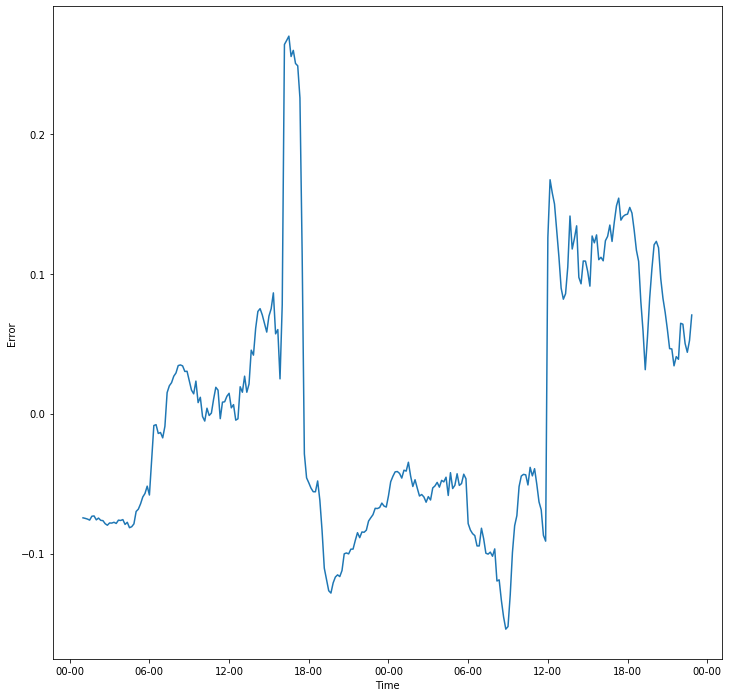

In [29]:
y = y_list_roll['error']
x = y_list_roll.index
fig, ax = plt.subplots(figsize=(12, 12))
date_form = DateFormatter("%H-%M")
ax.xaxis.set_major_formatter(date_form)
plt.plot(x, y)
plt.xlabel('Time')
plt.ylabel('Error')
plt.show()

## Naive time series prediction

In [155]:
def modelling_naive(x, y, time_start, time_end, hours=1, lag=6):
    # defining empty lists to store results
    rsquared = []
    mean_squared = []
    root_mean_squared = []
    explained_variance = []
    results = [rsquared, mean_squared, root_mean_squared, explained_variance]
    
    df_y = pd.DataFrame()
    df_y2 = pd.Series()
    
    date_list = pd.date_range(time_end, periods=hours, freq='H')
    for i in range(1,(len(date_list)-1)):
        train_frame = (x.index >= time_start) & (x.index < date_list[i])
        test_frame = (x.index >= date_list[i-1]) & (x.index < date_list[i+1])
        y_test = y[test_frame][lag:]
        # take the value of target_loss from 1 hour before the prediction
        y_last_train = y[train_frame][-12:-11].values
 
        y_pred = [y_last_train,y_last_train,y_last_train,y_last_train,y_last_train,y_last_train,]
        # evaluate results 
        mea, roo, expl, rsq = regr_eval(y_test, y_pred, return_scores=True, print_scores=False)
        df_y = df_y.append(pd.DataFrame(y_test))
        df_y2 = df_y2.append((pd.Series(y_pred, index=y_test.index)))
        
        rsquared.append(rsq)
        mean_squared.append(mea)
        root_mean_squared.append(roo)
        explained_variance.append(expl)
    
    # transforming results into a Dataframe
    df_y2 = pd.DataFrame(df_y2,index=df_y.index)
    df_y = df_y.join(df_y2, lsuffix="d")
    df_y = df_y.rename(columns={'target_losses_norm':'true',0:'predicted'})
    df_y['error'] = (df_y['true']-df_y['predicted']).astype(float)
    return results, df_y

In [156]:
#predicting one timeframe
timeframe_start = '2019-01-01 00:00'
timeframe_end = '2019-01-11 00:00'
results, y_list = modelling_naive(X, Y3, timeframe_start, timeframe_end, hours=48, lag=6)

In [157]:
# results of one timeframe
for i in range(1,3):
    lists = [ 'Root mean squared value','Mean squared value', 'Root mean squared value', 'Explained variance value']
    res = round((sum(results[i])/len(results[i])),10)
    print('The {} is: {}'.format(lists[i],res))

The Mean squared value is: 0.0087320008
The Root mean squared value is: 0.0597287674


In [158]:
timeframes = ['2019-01-11 00:00','2019-02-11 00:00','2019-03-20 00:00','2019-04-01 00:00','2019-06-05 00:00']

In [159]:
# predicting various timeframes - lag of 1 hour
for k,f in enumerate(timeframes):
    globals()["results_naive"+str(k)],globals()["y_list_naive"+str(k)] = modelling_naive(X, Y3, timeframe_start, f, hours=48, lag=6)

In [35]:
# results of various timeframes - lag of 1 hour
for f in range(len(timeframes)):
    print(timeframes[f])
    for i in range(1,3):
        lists = [ 'Root mean squared value','Mean squared value', 'Root mean squared value', 'Explained variance value']
        res = sum(globals()["results_naive" +str(f)][i])/len(globals()["results_naive"+str(f)][i])
        print('The {} is: {}'.format(lists[i],res))

2019-01-11 00:00
The Mean squared value is: 0.00873200079588084
The Root mean squared value is: 0.059728767394636464
2019-02-11 00:00
The Mean squared value is: 0.00893196005099639
The Root mean squared value is: 0.06516599429232967
2019-03-20 00:00
The Mean squared value is: 0.0025310320962750326
The Root mean squared value is: 0.03751745134470035
2019-04-01 00:00
The Mean squared value is: 0.0002633850577055315
The Root mean squared value is: 0.011399533261579466
2019-06-05 00:00
The Mean squared value is: 0.0018380074834674282
The Root mean squared value is: 0.028396828324704856


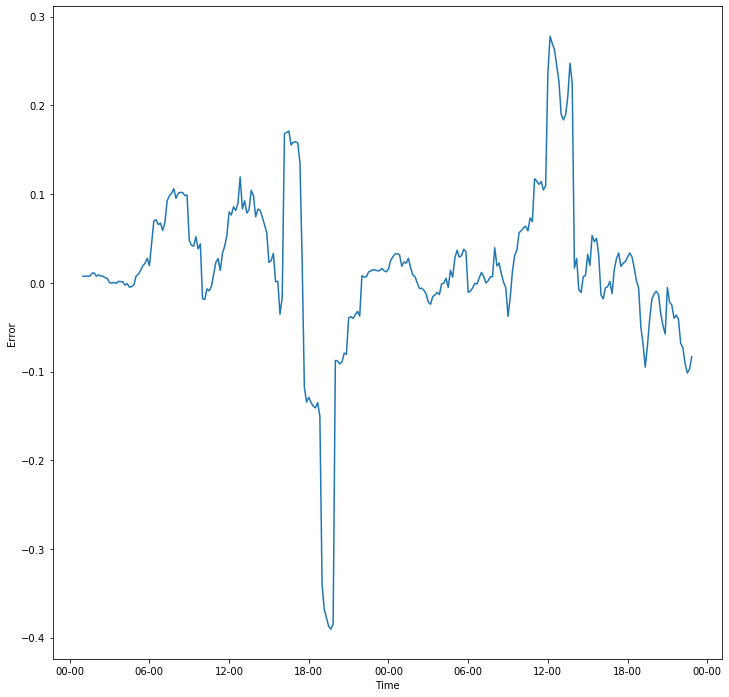

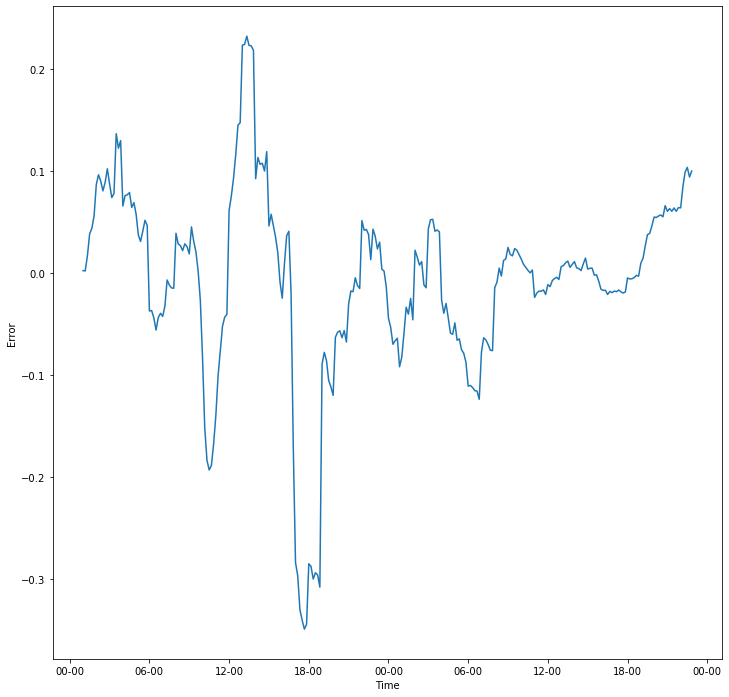

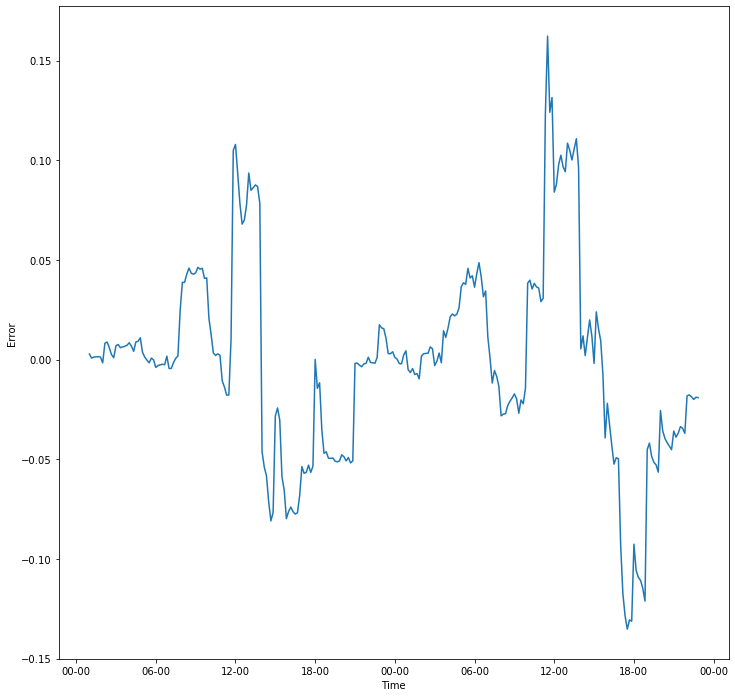

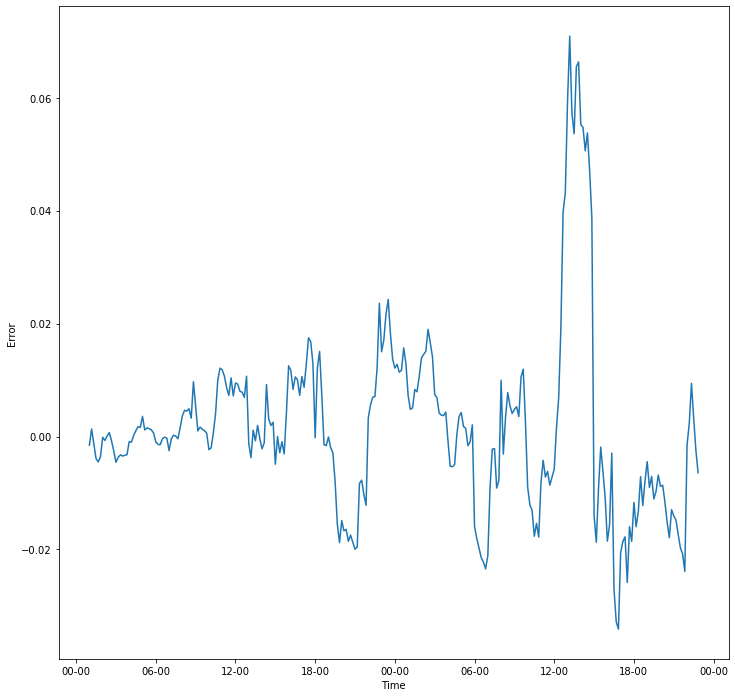

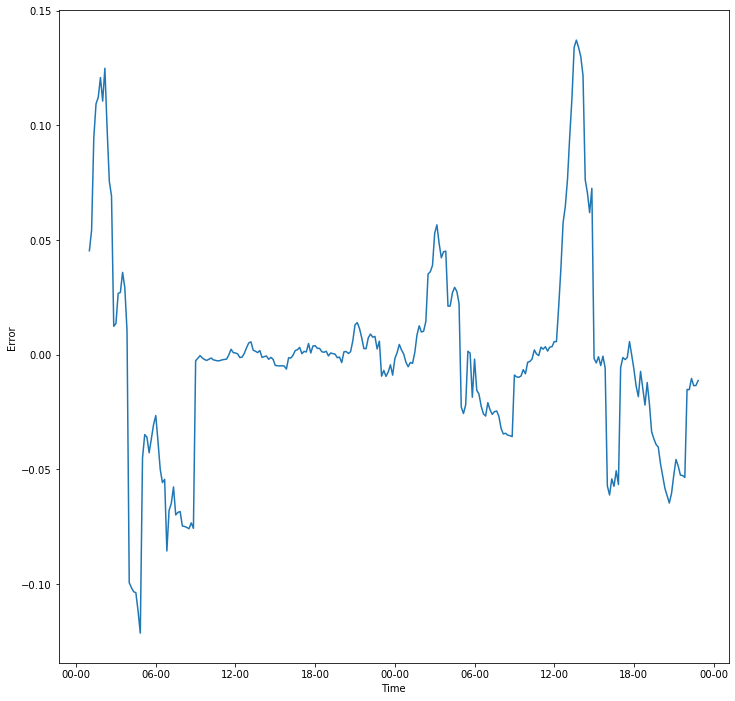

In [36]:
for i in range(len(timeframes)):
    y = globals()['y_list_naive'+str(i)]['error']
    x = globals()['y_list_naive'+str(i)].index
    fig, ax = plt.subplots(figsize=(12, 12))
    date_form = DateFormatter("%H-%M")
    ax.xaxis.set_major_formatter(date_form)
    plt.plot(x, y)
    plt.xlabel('Time')
    plt.ylabel('Error')
    plt.show()

## Comparing different regressors

In [37]:
timeframes = ['2019-01-11 00:00','2019-02-11 00:00','2019-03-20 00:00','2019-04-01 00:00','2019-06-05 00:00']

In [38]:
regression_type = [RandomForestRegressor(n_estimators=10, max_features='sqrt',max_depth=8, min_samples_leaf=10, random_state=1),
                   LinearRegression(n_jobs=10),
                   SVR(kernel='rbf'),
                   GradientBoostingRegressor(),
                   XGBRegressor(objective='reg:squarederror')]

regressor_str = ['RandomForest','LinReg','SVR','GradientBoosting','XGBReg']

In [39]:
for k,f in enumerate(timeframes):
    for d,i in enumerate(regression_type):
        globals()["results_" + str(d)+str(k)],globals()["y_list_" + str(d)+str(k)] = modelling_rolling(X, Y3, timeframe_start, f,
                                              i, 2, 6)

/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.

/Users/matthis/opt/anaconda3/envs/nf/lib/python3.6/site-packages/ipykernel_launcher.py:9: DeprecationWarning:

The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype expli

In [ ]:
# combining error lists for each date - lag of 1 hour
for f in range(len(timeframes)):
    globals()["df_errors"+str(f)] = pd.DataFrame(index=globals()["y_list_" + '0'+str(f)].index)
    for k in range(len(regressor_str)):
        globals()["df_errors"+str(f)] = globals()["df_errors"+str(f)].join(globals()["y_list_" + str(k)+str(f)]['error'],rsuffix=regressor_str[k])
    globals()["df_errors"+str(f)] = globals()["df_errors"+str(f)].rename(columns={'error':'Random forest','errorLinReg':'Linear Reg','errorSVR':'SVR',
                                      'errorGradientBoosting':'GradBoosting','errorXGBReg':'XGBoost'})
    plot_errors(globals()["df_errors"+str(f)])

In [ ]:
# results predicting different timeslots with different regressors - lag of 2 hours
#for f in range(len(timeframes)):
#    print(timeframes[f])
#    for k in range(len(regressor_str)):
#        print(regressor_str[k])
#        for i in range(1,3):
#            lists = [ 'Root mean squared value','Mean squared value', 'Root mean squared value', 'Explained variance value']
#            res = sum(globals()["results_" + str(k)+str(f)][i])/len(globals()["results_" + str(k)+str(f)][i])
#            print('The {} is: {}'.format(lists[i],res))

In [ ]:
# Results for preprocessed data
#for f in range(len(timeframes)):
#    globals()["df_errors"+str(f)] = pd.DataFrame(index=globals()["y_list_" + '0'+str(f)].index)
#    for k in range(len(regressor_str)):
#        globals()["df_errors"+str(f)] = globals()["df_errors"+str(f)].join(globals()["y_list_" + str(k)+str(f)]['error'],rsuffix=regressor_str[k])
#    globals()["df_errors"+str(f)] = globals()["df_errors"+str(f)].rename(columns={'error':'Random forest','errorLinReg':'Linear Reg','errorSVR':'SVR',
#                                      'errorGradientBoosting':'GradBoosting','errorXGBReg':'XGBoost'})
#    plot_errors(globals()["df_errors"+str(f)])

In [ ]:
# Results for preprocessed data
#for f in range(len(timeframes)):
#    print(timeframes[f])
#    for k in range(len(regressor_str)):
#        print(regressor_str[k])
#        for i in range(1,3):
#            lists = [ 'Root mean squared value','Mean squared value', 'Root mean squared value', 'Explained variance value']
#            res = sum(globals()["results_" + str(k)+str(f)][i])/len(globals()["results_" + str(k)+str(f)][i])
#            print('The {} is: {}'.format(lists[i],res))

In [ ]:
# combining error lists for each date - lag of 2 hours
#for f in range(len(timeframes)):
#    globals()["df_errors"+str(f)] = pd.DataFrame(index=globals()["y_list_" + '0'+str(f)].index)
#    for k in range(len(regressor_str)):
#        globals()["df_errors"+str(f)] = globals()["df_errors"+str(f)].join(globals()["y_list_" + str(k)+str(f)]['error'],rsuffix=regressor_str[k])
#    globals()["df_errors"+str(f)] = globals()["df_errors"+str(f)].rename(columns={'error':'Random forest','errorLinReg':'Linear Reg','errorSVR':'SVR',
#                                      'errorGradientBoosting':'GradBoosting','errorXGBReg':'XGBoost'})
#    plot_errors(globals()["df_errors"+str(f)])

In [ ]:
# results predicting different timeslots with different regressors - lag of 2 hours
#for f in range(len(timeframes)):
#    print(timeframes[f])
#    for k in range(len(regressor_str)):
#        print(regressor_str[k])
#        for i in range(1,3):
#            lists = [ 'Root mean squared value','Mean squared value', 'Root mean squared value', 'Explained variance value']
#            res = sum(globals()["results_" + str(k)+str(f)][i])/len(globals()["results_" + str(k)+str(f)][i])
#            print('The {} is: {}'.format(lists[i],res))

## Time Series Models

### Plots for time series

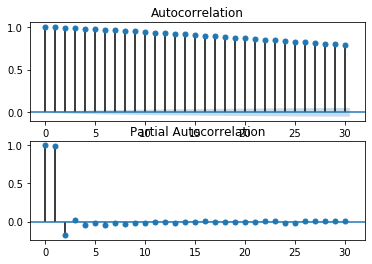

In [41]:
# ACF, PACF
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

plt.figure()
plt.subplot(211)
plot_acf(Y3, ax=plt.gca(), lags = 30)
plt.subplot(212)
plot_pacf(Y3, ax=plt.gca(), lags = 30)
plt.show()

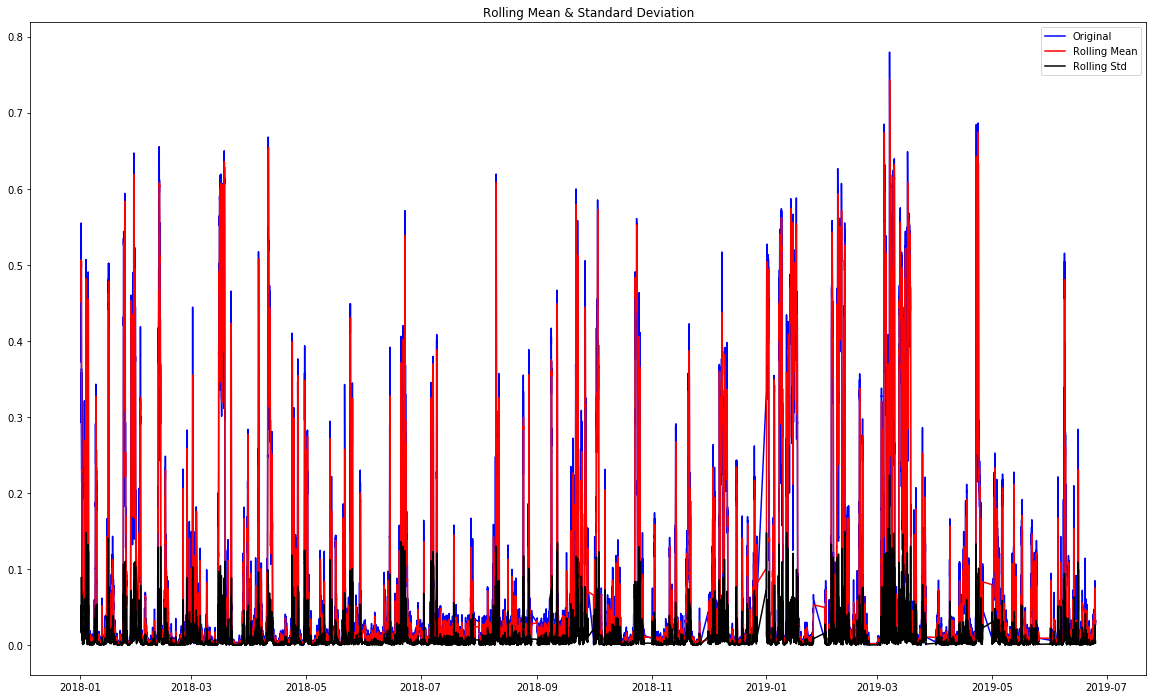

Results of Dickey-Fuller Test:
Test Statistic                -1.398105e+01
p-value                        4.176917e-26
#Lags Used                     6.100000e+01
Number of Observations Used    7.061200e+04
Critical Value (1%)           -3.430443e+00
Critical Value (5%)           -2.861581e+00
Critical Value (10%)          -2.566792e+00
dtype: float64


In [42]:
from statsmodels.tsa.stattools import adfuller

#Determing rolling statistics
rolmean = pd.Series(Y3).rolling(window=12).mean()
rolstd = pd.Series(Y3).rolling(window=12).std()

#Plot rolling statistics:
fig, ax = plt.subplots(figsize=(20,12))
orig = plt.plot(Y3, color='blue',label='Original')
mean = plt.plot(rolmean, color='red', label='Rolling Mean')
std = plt.plot(rolstd, color='black', label = 'Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)
    
#Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(Y3, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

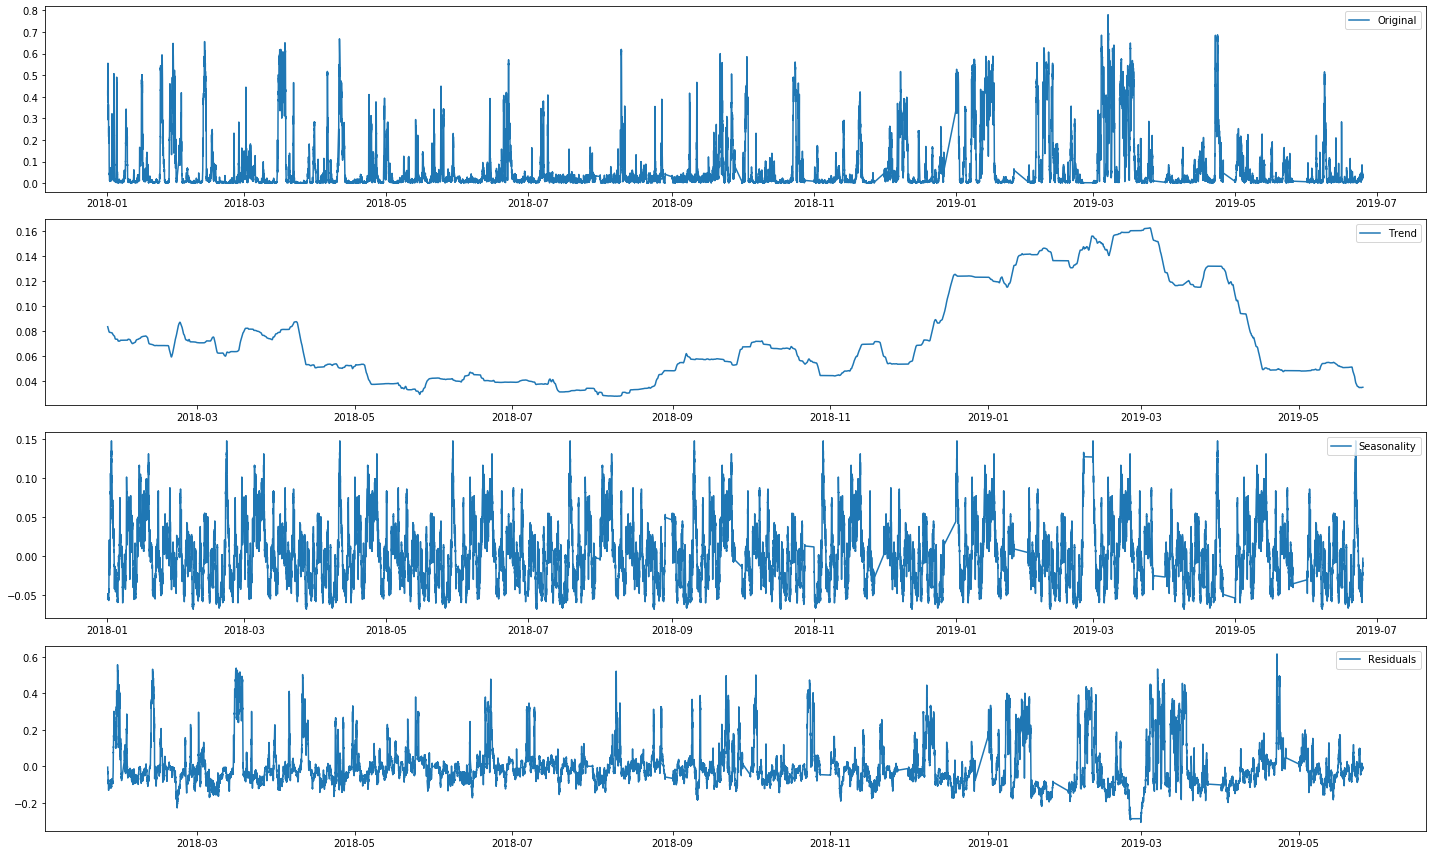

In [43]:
# Seasonal trends
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(Y3,period=7000)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

fig,ax = plt.subplots(figsize=(20,12))
plt.subplot(411)
plt.plot(Y3, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [44]:
ts_log = np.log(Y3)
ts_log_diff = ts_log- ts_log.shift(6)
#ts_y3_diff = Y3-Y3.shift(6)
ts_log_diff.dropna(inplace=True)
model = AR(ts_log_diff)
model_fit = model.fit()

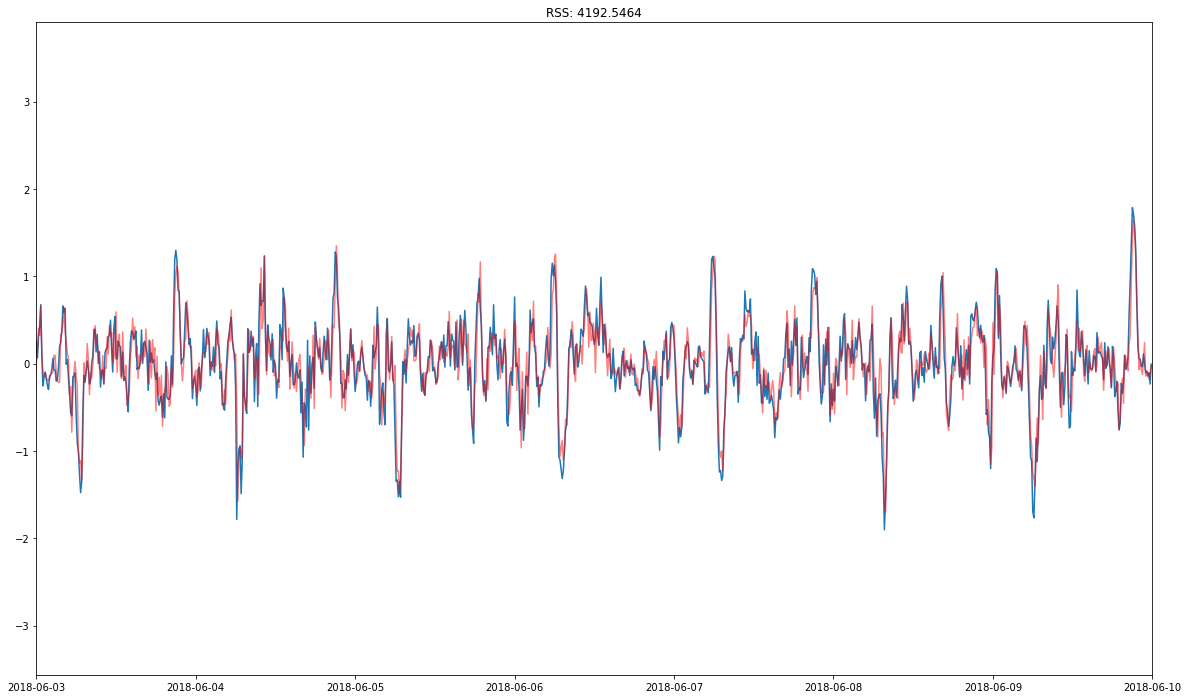

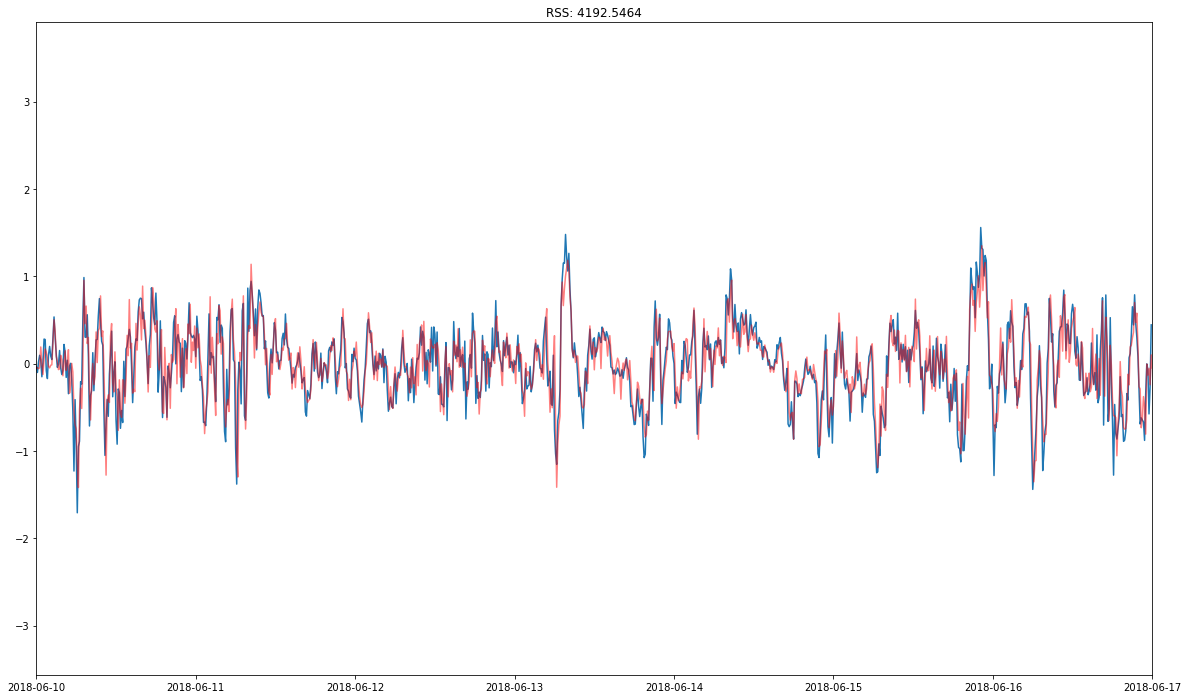

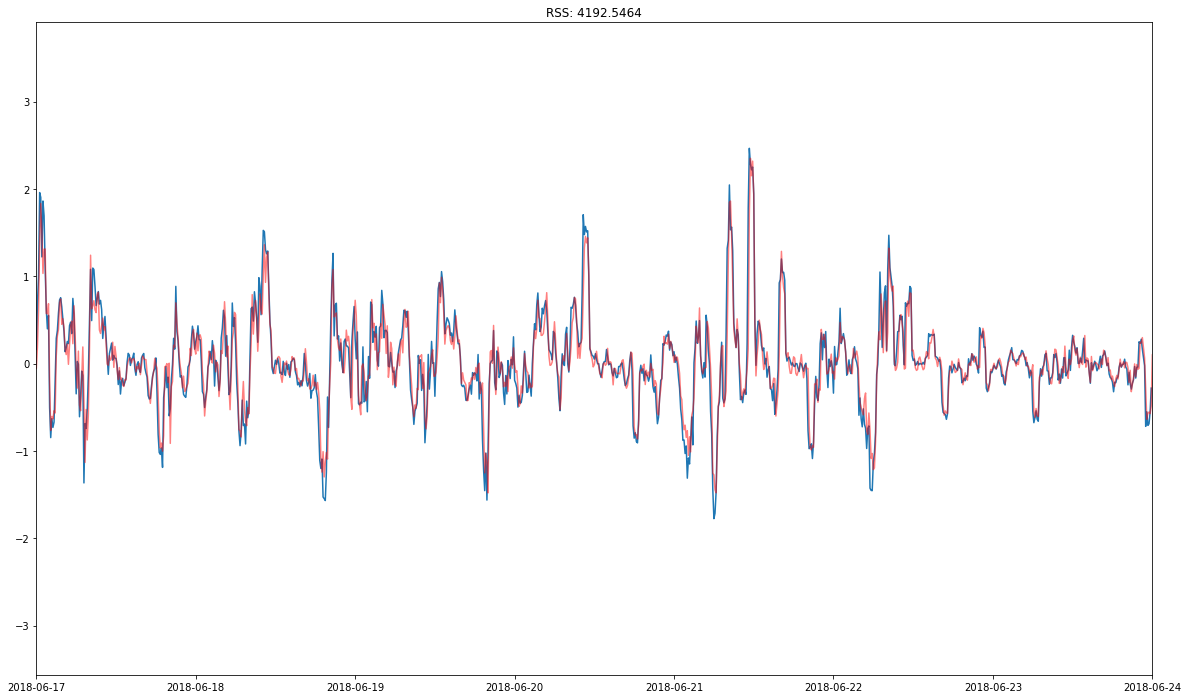

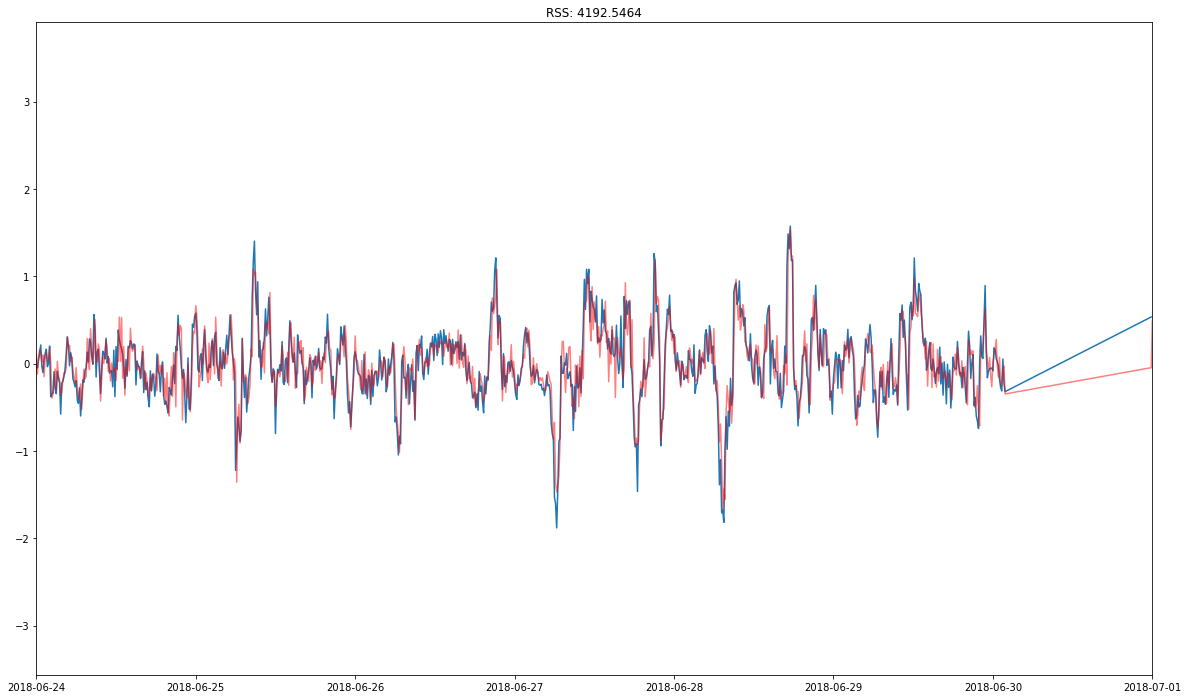

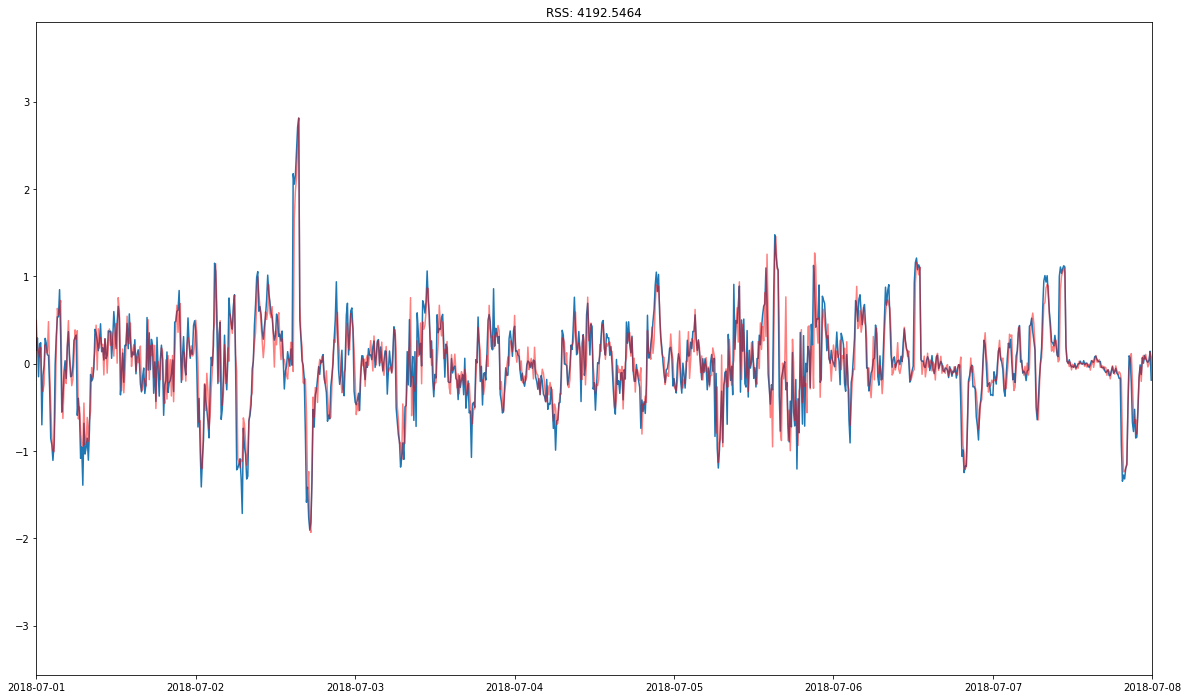

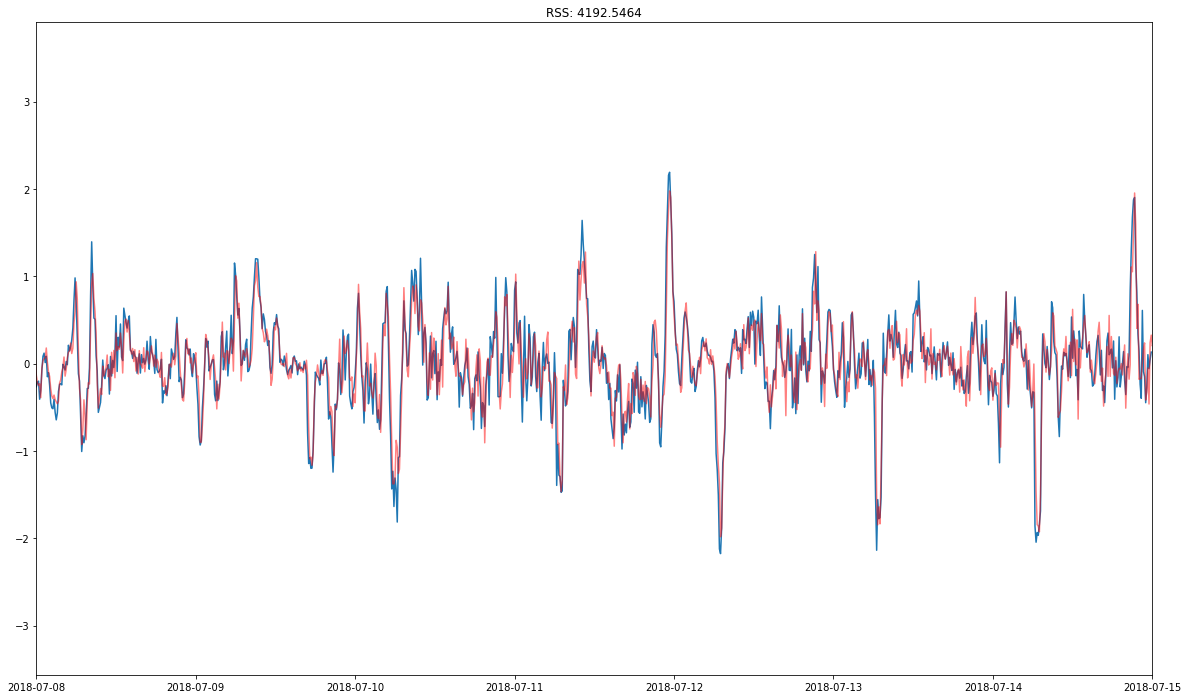

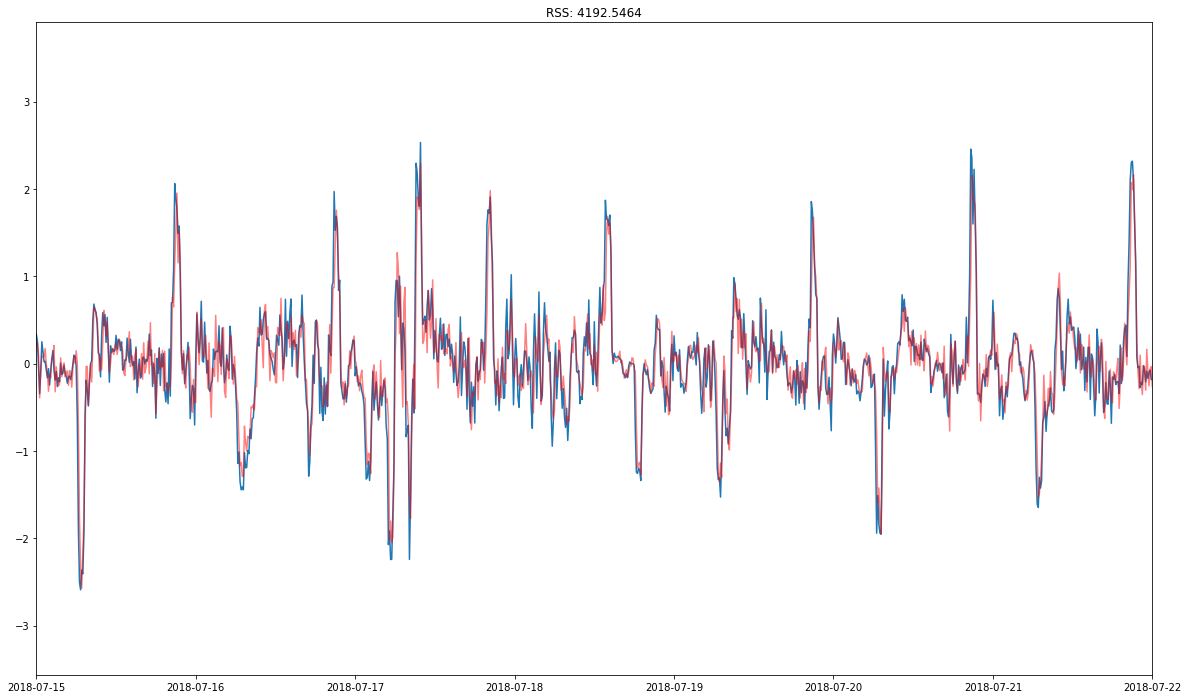

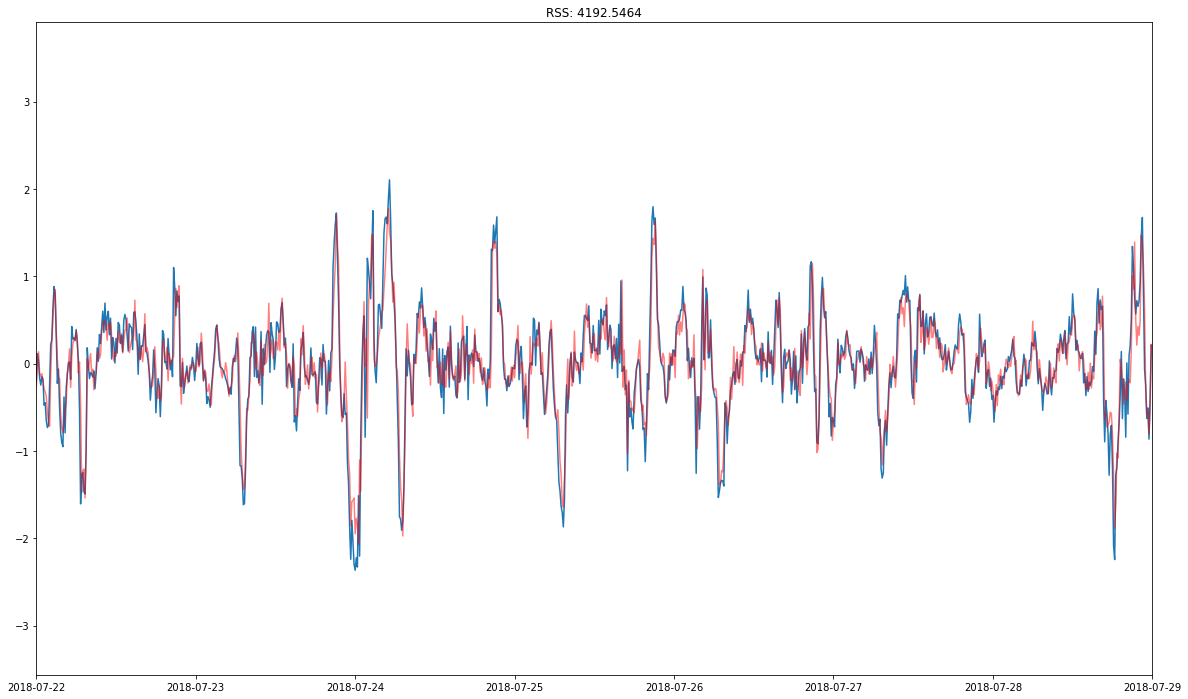

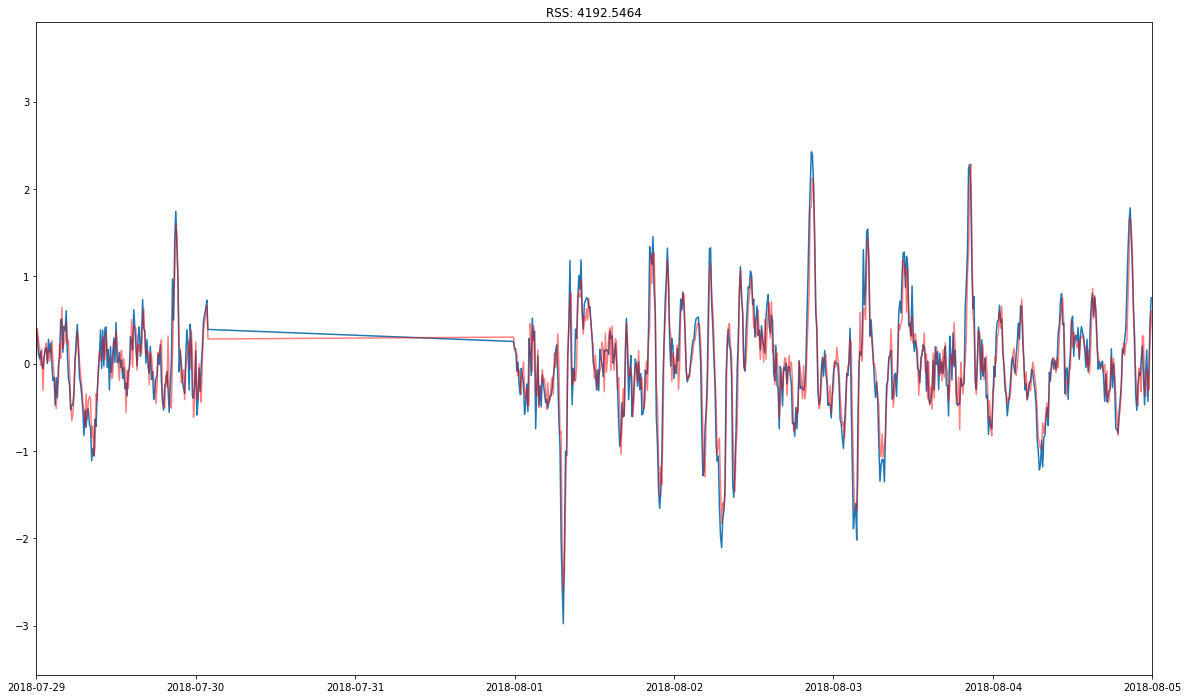

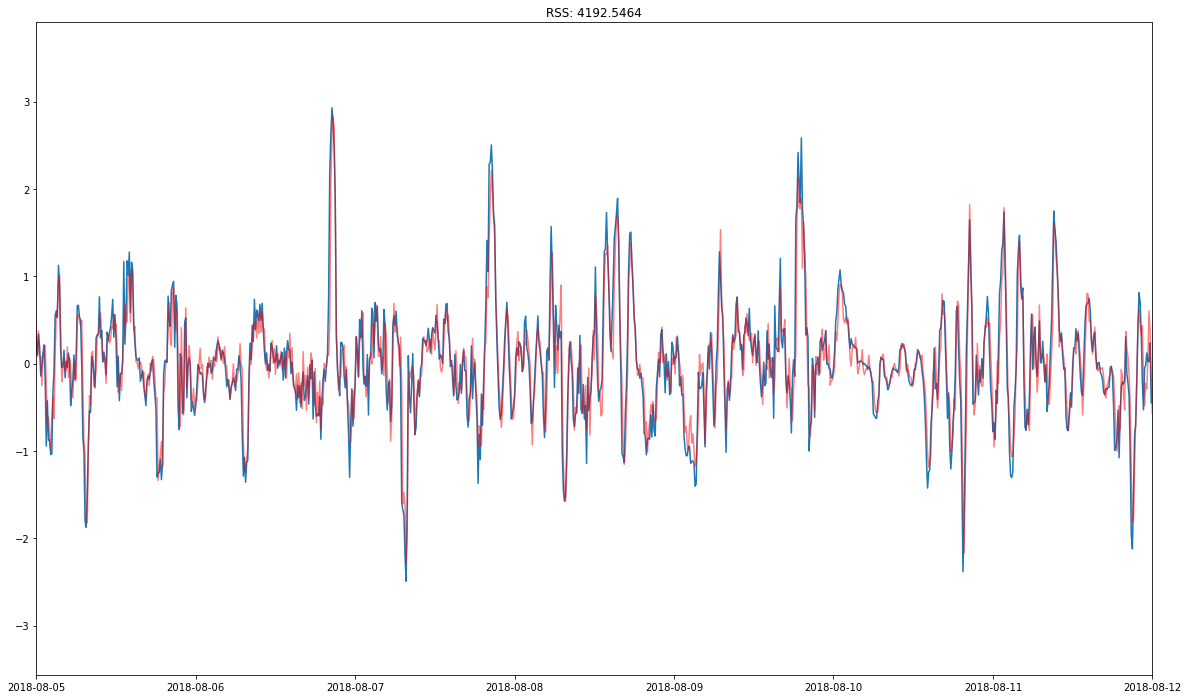

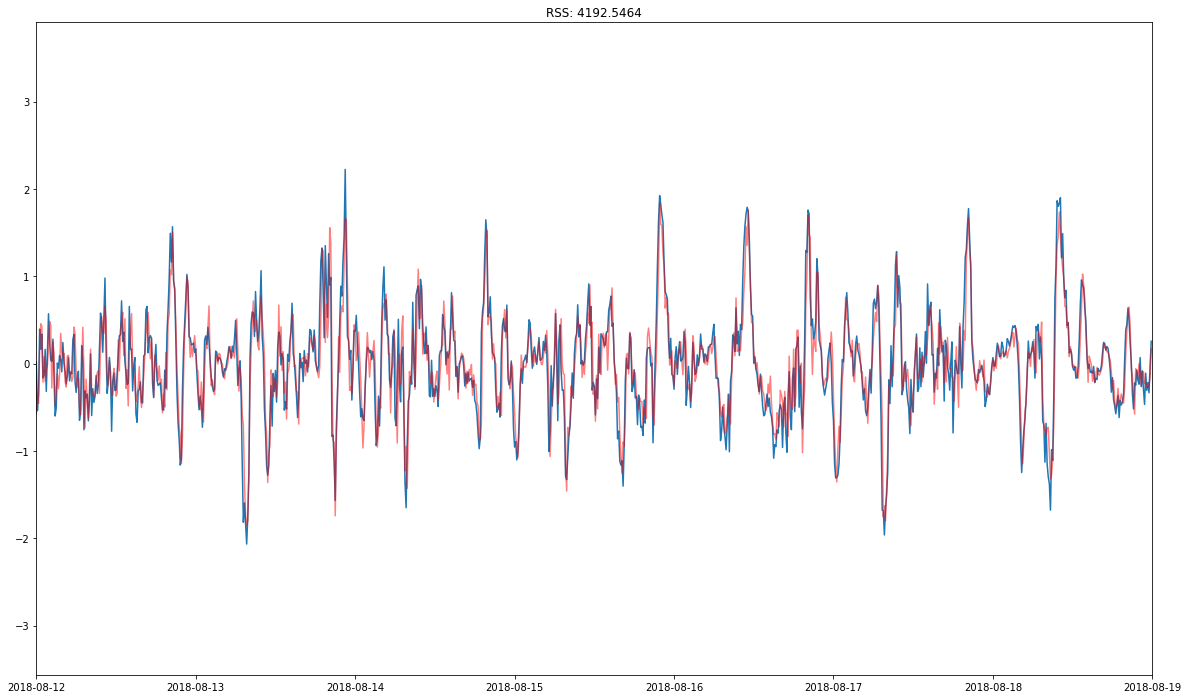

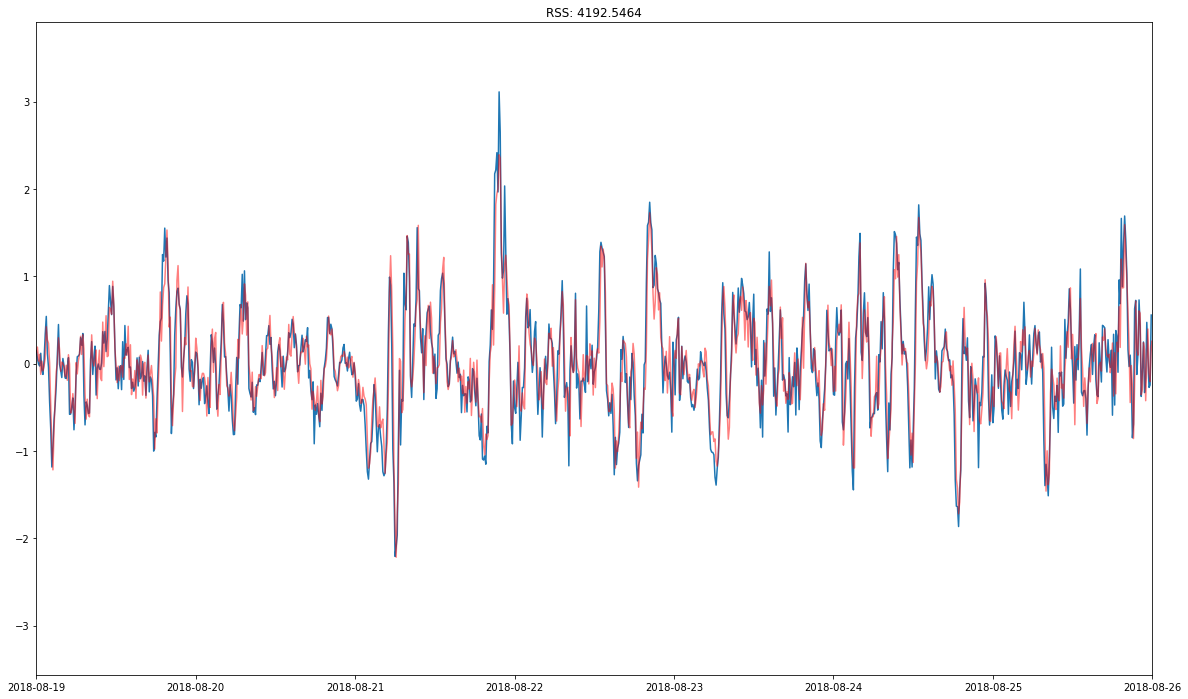

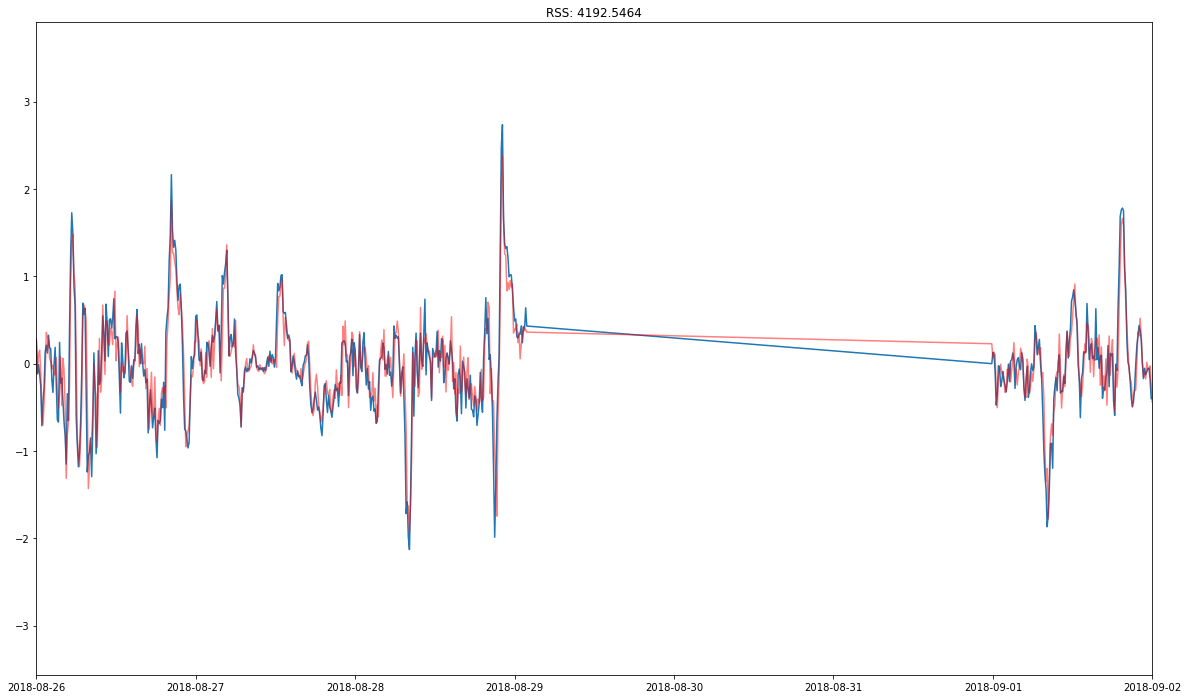

In [45]:
date_list = pd.date_range('2018-06-01 00:00', periods=14, freq='W')
for i in range(len(date_list)-1):
    timeframe = (ts_log_diff.index >= date_list[i]) & (ts_log_diff.index < date_list[i+1])
    fig,ax = plt.subplots(figsize=(20,12))
    plt.plot(ts_log_diff[timeframe])
    plt.xlim(left=date_list[i],right=date_list[i+1])
    plt.plot(model_fit.fittedvalues, color='red',alpha=0.5)
    plt.title('RSS: %.4f'% np.nansum((model_fit.fittedvalues-ts_log_diff)**2))
    plt.show()

In [ ]:
predictions_ARIMA_diff = pd.Series(model_fit.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head())
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print (predictions_ARIMA_diff_cumsum.head())
predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(Y3)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(np.nansum((predictions_ARIMA-Y3)**2)/len(Y3)))

In [ ]:
evaluate_forecast(Y3, predictions_ARIMA)

In [ ]:
series = pd.Series(Y3)
model = ARIMA(series, order=(6,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [ ]:
#    X = series.values
#    size = int(len(X) * 0.95)
#    train, test = X[0:size], X[size:len(X)]
#    history = [x for x in train]
#    predictions = list()
#    for t in range(len(test)):
#        model = ARIMA(history, order=(5,1,0))
#        model_fit = model.fit(disp=0)
#        output = model_fit.forecast()
#        yhat = output[0]
#        predictions.append(yhat)
#        obs = test[t]
#        history.append(obs)
#        #print('predicted=%f, expected=%f' % (yhat, obs))
#    error = mean_squared_error(test, predictions)
#    print('Test MSE: %.3f' % error)
#    # plot
#    pyplot.plot(test)
#    pyplot.plot(predictions, color='red')
#    pyplot.show()

In [ ]:
fig, ax = plt.subplots(figsize=(20,10))
plt.plot(test,color='orange')
plt.plot(predictions,color='b',alpha=0.5)
plt.show()

In [ ]:
error = abs(test-predictions)


## ARIMA

In [74]:
def modelling_arima(X,tfstart,lag):
  #  series = pd.Series(X)
  #  X = series.values
    tfend = pd.to_datetime(tfstart) + pd.Timedelta(hours=48)
    y_list = X[(X.index >= tfstart) & (X.index <= tfend)]
    x_list = X[(X.index < tfstart)]
    size = X[tfstart] 
    end = X[tfend]
    train, test = x_list, y_list
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=(lag,1,0))
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = output[0]
        predictions.append(yhat)
        obs = test[t]
        history.append(obs)
        print('predicted=%f, expected=%f' % (yhat, obs))
    return y_list, predictions

In [75]:
# single timeslot
y_list , predictions = modelling_arima(Y3, '2019-01-13 00:00:00', lag=6)

In [79]:
# all timeframes in timeframes
for k,f in enumerate(timeframes):
    globals()["results_arima"+str(k)],globals()["y_list_arima"+str(k)] = modelling_arima(Y3, f, lag=6)

In [133]:
for k,f in enumerate(timeframes):
    globals()["y_list_arima1"+str(k)] = [l.tolist() for l in (globals()["y_list_arima"+str(k)])]
    globals()["y_list_arima2"+str(k)] = []
    for i in globals()["y_list_arima1"+str(k)]:
        globals()["y_list_arima2"+str(k)] += i
    globals()["y_list_arima2"+str(k)] = pd.Series(globals()["y_list_arima2"+str(k)], index=globals()["results_arima"+str(k)].index, name='yhat')

In [135]:
# storing arima results and error in df_arima0-4
for k,f in enumerate(timeframes):
    globals()["df_arima"+str(k)] = pd.DataFrame(globals()["results_arima"+str(k)])
    globals()["df_arima"+str(k)] = globals()["df_arima"+str(k)].join((globals()["y_list_arima2"+str(k)]),lsuffix='d')
    globals()["df_arima"+str(k)]['error'] = globals()["results_arima"+str(k)]-globals()["y_list_arima2"+str(k)]

## LSTM Recurrent neural network

In [174]:

import numpy
import matplotlib.pyplot as plt
import pandas
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

Using TensorFlow backend.


In [175]:
dataframe = pd.DataFrame(Y3)

In [176]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return numpy.array(dataX), numpy.array(dataY)
# fix random seed for reproducibility
numpy.random.seed(7)
dataset = dataframe.values
dataset = dataset.astype('float32')
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]
# reshape into X=t and Y=t+1
look_back = 3
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))
# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=4, batch_size=1, verbose=2)


Epoch 1/4
 - 133s - loss: 3.7783e-04
Epoch 2/4
 - 182s - loss: 1.3246e-04
Epoch 3/4
 - 198s - loss: 1.2742e-04
Epoch 4/4
 - 193s - loss: 1.2625e-04


Train Score: 0.01 RMSE
Test Score: 0.01 RMSE


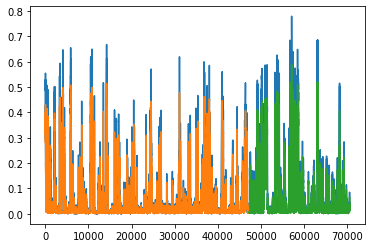

In [177]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(dataset)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(dataset)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [202]:
testPredict

array([[0.00551627],
       [0.00626521],
       [0.00935454],
       ...,
       [0.02068877],
       [0.0262061 ],
       [0.02390841]], dtype=float32)

In [198]:
df_lstm = dataframe[-23319:]

In [199]:
df_lstm

target_losses_norm
2018-12-14 12:30:00            0.011074
2018-12-14 12:40:00            0.009948
2018-12-14 12:50:00            0.006341
2018-12-14 13:00:00            0.009535
2018-12-14 13:10:00            0.006308
...                                 ...
2019-06-25 01:10:00            0.026618
2019-06-25 01:20:00            0.033104
2019-06-25 01:30:00            0.031078
2019-06-25 01:40:00            0.030189
2019-06-25 01:50:00            0.030705

[23319 rows x 1 columns]

In [210]:
testPredict = testPredict.tolist()
testPredict1 = []
for i in testPredict:
    testPredict1 += i

In [216]:
testPredict1=pd.Series(testPredict1, index=df_lstm.index, name='L')

In [217]:
df_lstm = df_lstm.join(testPredict1, rsuffix='d')

In [219]:
df_lstm['errors'] = df_lstm['target_losses_norm']-df_lstm['L']
df_lstm

target_losses_norm         L    errors
2018-12-14 12:30:00            0.011074  0.005516  0.005557
2018-12-14 12:40:00            0.009948  0.006265  0.003683
2018-12-14 12:50:00            0.006341  0.009355 -0.003013
2018-12-14 13:00:00            0.009535  0.008082  0.001452
2018-12-14 13:10:00            0.006308  0.005200  0.001108
...                                 ...       ...       ...
2019-06-25 01:10:00            0.026618  0.021259  0.005358
2019-06-25 01:20:00            0.033104  0.021180  0.011924
2019-06-25 01:30:00            0.031078  0.020689  0.010390
2019-06-25 01:40:00            0.030189  0.026206  0.003983
2019-06-25 01:50:00            0.030705  0.023908  0.006796

[23319 rows x 3 columns]

In [220]:
df_together = df_errors0.join(df_lstm['errors'])

In [221]:
df_together

Random forest  Linear Reg       SVR  GradBoosting  \
2019-01-11 01:00:00      -0.013565   -0.068018  0.016173     -0.023345   
2019-01-11 01:10:00      -0.012577   -0.067444  0.017521     -0.023252   
2019-01-11 01:20:00      -0.011107   -0.066969  0.018645     -0.025508   
2019-01-11 01:30:00      -0.010152   -0.066739  0.019402     -0.025758   
2019-01-11 01:40:00      -0.010490   -0.062989  0.023555     -0.022490   
...                            ...         ...       ...           ...   
2019-01-12 22:10:00      -0.036272    0.047413 -0.000481     -0.034204   
2019-01-12 22:20:00      -0.037398    0.035374 -0.013435     -0.052223   
2019-01-12 22:30:00      -0.047897    0.030853 -0.018881     -0.062722   
2019-01-12 22:40:00       0.008311    0.041079 -0.009593      0.014719   
2019-01-12 22:50:00       0.086549    0.061075  0.009452      0.085720   

                      XGBoost     Naive     Arima  target_losses_norm  \
2019-01-11 01:00:00 -0.028872  0.007525  0.000981            0.009762   
2019-01-11 01:10:00 -0.030469  0.007618 -0.000265            0.009855   
2019-01-11 01:20:00 -0.030477  0.007611 -0.000033            0.009848   
2019-01-11 01:30:00 -0.030727  0.007361 -0.000406            0.009597   
2019-01-11 01:40:00 -0.027459  0.010629  0.003274            0.012866   
...                       ...       ...       ...                 ...   
2019-01-12 22:10:00 -0.031446 -0.073041 -0.008619            0.329748   
2019-01-12 22:20:00 -0.048410 -0.091059 -0.015601            0.311730   
2019-01-12 22:30:00 -0.058909 -0.101559 -0.008349            0.301230   
2019-01-12 22:40:00  0.013277 -0.097311  0.005606            0.305478   
2019-01-12 22:50:00  0.083615 -0.083294  0.012848            0.319495   

                            L    errors  
2019-01-11 01:00:00  0.008218  0.001544  
2019-01-11 01:10:00  0.007390  0.002465  
2019-01-11 01:20:00  0.008127  0.001721  
2019-01-11 01:30:00  0.008130  0.001467  
2019-01-11 01:40:00  0.008120  0.004746  
...                       ...       ...  
2019-01-12 22:10:00  0.244684  0.085064  
2019-01-12 22:20:00  0.265479  0.046250  
2019-01-12 22:30:00  0.259021  0.042210  
2019-01-12 22:40:00  0.243296  0.062181  
2019-01-12 22:50:00  0.235707  0.083788  

[276 rows x 10 columns]

## Comparing results

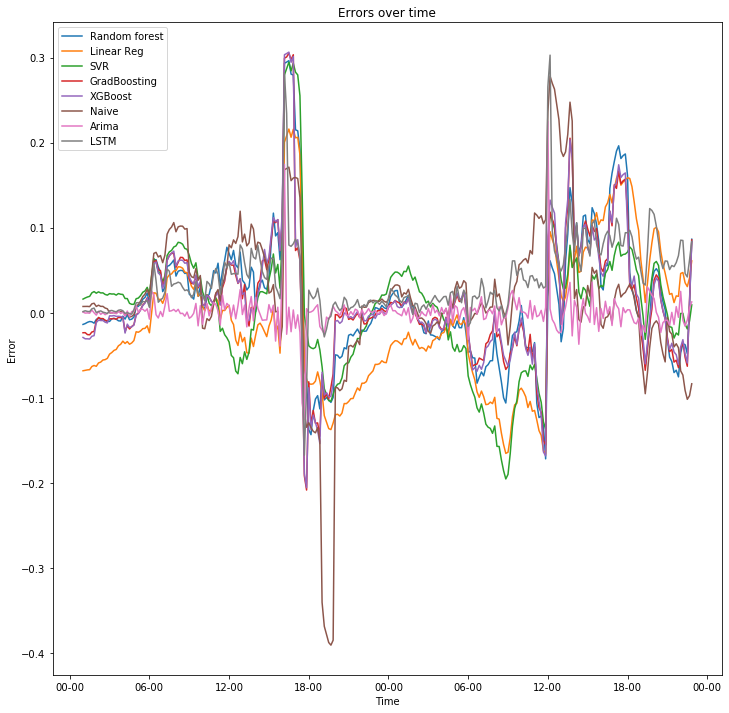

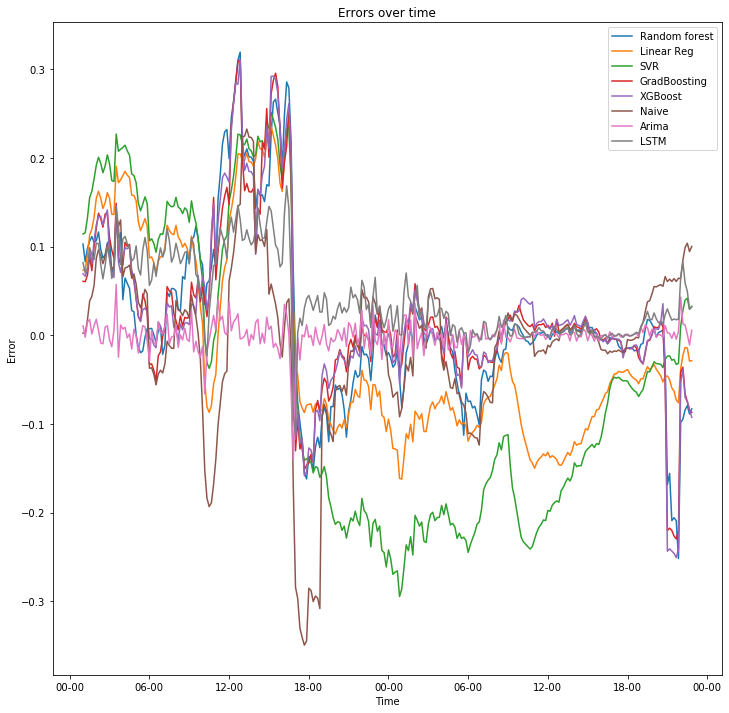

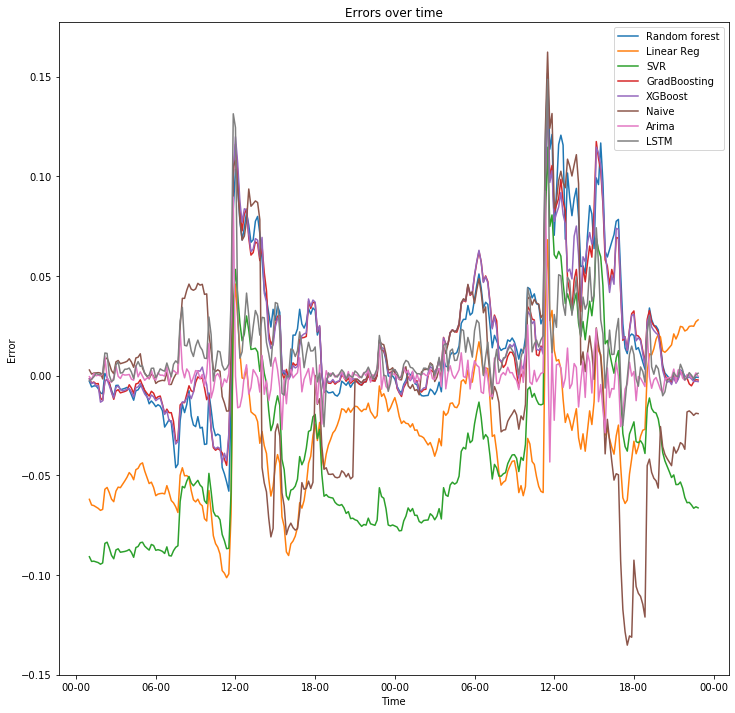

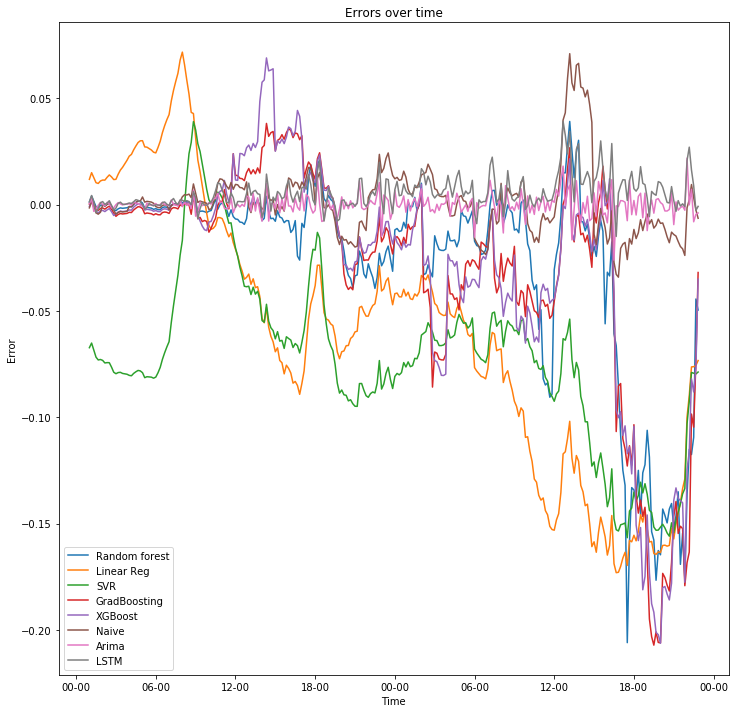

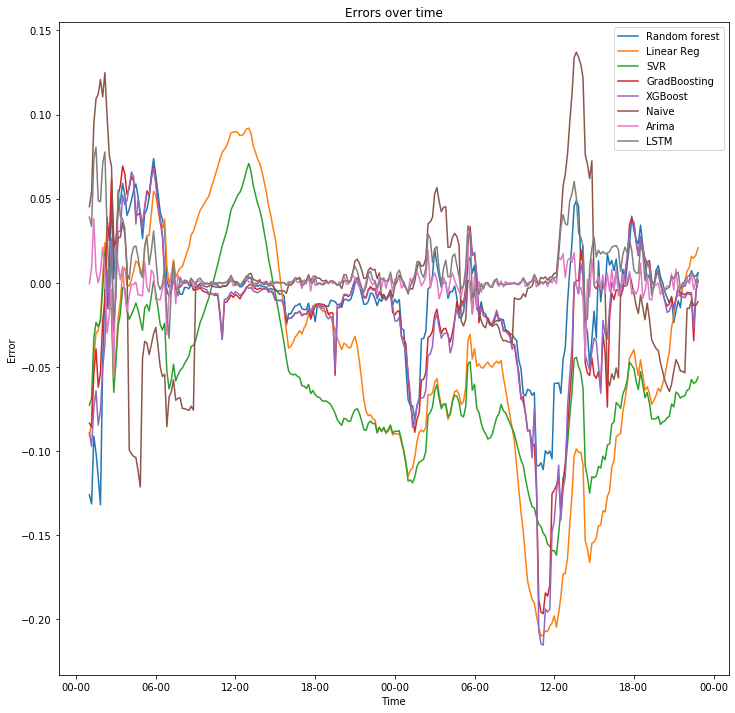

In [225]:
for f in range(len(timeframes)):
    globals()["df_errors"+str(f)] = pd.DataFrame(index=globals()["y_list_" + '0'+str(f)].index)
    for k in range(len(regressor_str)):
        globals()["df_errors"+str(f)] = globals()["df_errors"+str(f)].join(globals()["y_list_" + str(k)+str(f)]['error'],rsuffix=regressor_str[k])
    globals()["df_errors"+str(f)] = globals()["df_errors"+str(f)].join(globals()['y_list_naive'+str(f)]['error'], rsuffix='naive')
    globals()["df_errors"+str(f)] = globals()["df_errors"+str(f)].join(globals()['df_arima'+str(f)]['error'],rsuffix='arima')
    globals()["df_errors"+str(f)] = globals()["df_errors"+str(f)].join(df_lstm['errors'], rsuffix='lstm')
    globals()["df_errors"+str(f)] = globals()["df_errors"+str(f)].rename(columns={'error':'Random forest','errorLinReg':'Linear Reg','errorSVR':'SVR',
                                      'errorGradientBoosting':'GradBoosting','errorXGBReg':'XGBoost','errornaive':'Naive','errorarima':'Arima','errors':'LSTM'})
    plot_errors(globals()["df_errors"+str(f)])

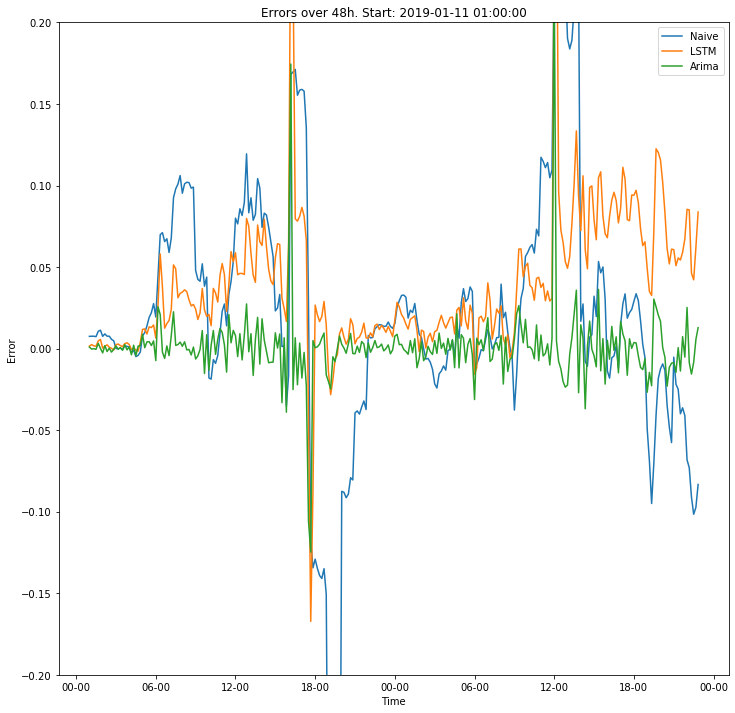

In [248]:
plot_errors(df_errors0[['Naive','LSTM','Arima']])

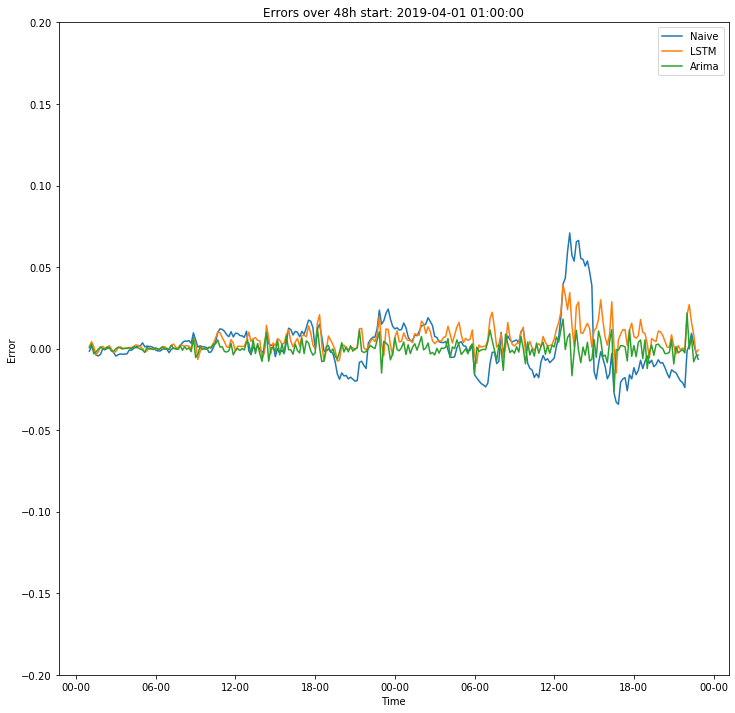

In [243]:
plot_errors(df_errors3[['Naive','LSTM','Arima']])

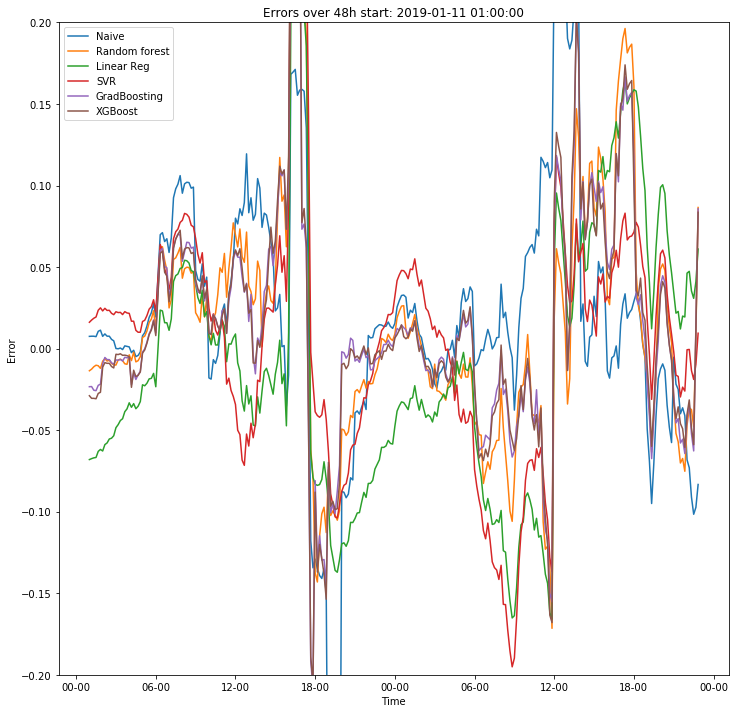

In [244]:
plot_errors(df_errors0[['Naive','Random forest','Linear Reg','SVR','GradBoosting','XGBoost']])

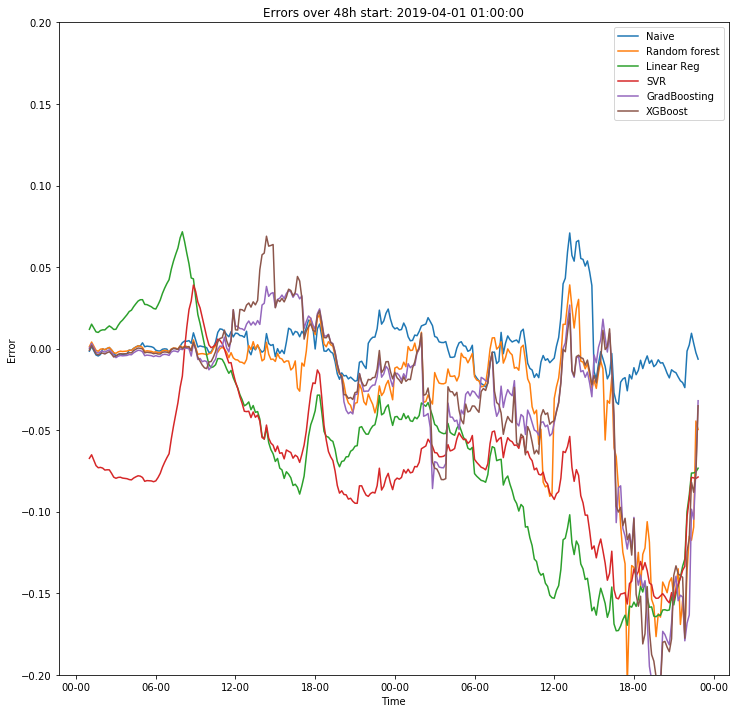

In [246]:
plot_errors(df_errors3[['Naive','Random forest','Linear Reg','SVR','GradBoosting','XGBoost']])

# API

## Openweather API (hourly forecast)

In [ ]:
openweather_api_key ='f1afaaf6a82c52ed15b283488ae2f377'
openweather_api_url = 'https://api.openweathermap.org/data/2.5/weather?lat={lat}&lon={lon}&units=metric&appid={your api key}'

urllib.request.urlopen(openweather_api_url).read() 
response = urllib.request.urlopen(openweather_api_url).read()
json_obj = str(response, 'utf-8')
forecast_load = json.loads(json_obj)

In [ ]:
def forecast(lat,long):
    url='https://api.openweathermap.org/data/2.5/onecall?lat={}&lon={}&exclude=current,minutely,daily&units=metric&appid=f1afaaf6a82c52ed15b283488ae2f377'.format(lat,long)
    urllib.request.urlopen(url).read() 
    response = urllib.request.urlopen(url).read()
    json_obj = str(response, 'utf-8')
    forecast_load = json.loads(json_obj)
    df_forecast = pd.DataFrame(forecast_load['hourly']).copy()
    df_forecast['dt'] = df_forecast.dt.apply(lambda x : datetime.fromtimestamp(x))
    df_forecast = df_forecast.set_index('dt')
    forecast_cols = ['clouds', 'dew_point', 'feels_like', 'humidity', 'pop','visibility', 'weather']
    dict_forec = {'wind_speed':'wsp_10m_ms','temp':'t_2m_k','wind_deg':'wdir_10m_dn','pressure':'msl_ms_pa'}

    if len(df_forecast.columns)>4:
        for i in forecast_cols:
            df_forecast.pop(i)
    df_forecast = df_forecast.rename(columns=dict_forec)
    df_forecast['msl_ms_pa'] = df_forecast['msl_ms_pa'].apply(lambda x : x*100)
    df_forecast['t_2m_k'] = df_forecast['t_2m_k'].apply(lambda x : x+273,15)

    x_train_forecast = df[['msl_ms_pa', 't_2m_k', 
                           'wdir_10m_dn',
                           'wsp_10m_ms','wsp_100m_ms']].copy()
    y_train_forecast = df['target_losses_norm'].copy()
    x_test_forecast = df_forecast[['msl_ms_pa', 't_2m_k', 
                           'wdir_10m_dn',
                           'wsp_10m_ms']].copy()
    x_test_forecast['wsp_100m_ms'] = x_test_forecast['wsp_10m_ms'].apply(lambda x: x/0.64)

    rfr_model = RandomForestRegressor(n_estimators=10, max_features='sqrt',max_depth=8, min_samples_leaf=10)
    y_train_forecast_pred = cross_val_predict(rfr_model, x_train_forecast, y_train_forecast)
    rfr_model = rfr_model.fit(x_train_forecast, y_train_forecast)
    y_test_forecast_pred = rfr_model.predict(x_test_forecast)
    regr_eval(y_train_forecast, y_train_forecast_pred)
    y_test_forecast_pred = pd.DataFrame(y_test_forecast_pred,index=x_test_forecast.index)
    plt.plot(y_test_forecast_pred)
    plt.title('Forecast for latitude {} and longitude {}'.format(lat,long))
    plt.xticks(rotation=45)
    plt.show()
    return y_test_forecast_pred.rename(columns={0:'target_losses_norm'})

In [ ]:
forecast(52.790042, 8.649624)

- dict with location and coordinates as a tuple

- 6 lat and long coordinates with historical Data to teach the model (calculate wsp100m with ratio of last year)

- getting the current weather forecast via api

- predict einsman actions over the next 48 hours with forecast

- visualize einsman actions in a dashboard with a map(slider for 48 hours), raw data

- hourly and monthly average of ratio between wsp 10 and wsp100


## Climacell API (10 minutely forecast - 6hrs)

In [ ]:
climacell_api_key = 'QaNtMY27bUQcSLQrQuG5u2k3lZwNAm9a'
climacell_api_url = 'https://api.climacell.co/v3/locations?apikey=QaNtMY27bUQcSLQrQuG5u2k3lZwNAm9a'

In [ ]:
url = "https://api.climacell.co/v3/weather/nowcast"
querystring = {"lat":"52.790042","lon":"8.649624","unit_system":"si","timestep":"10","start_time":"now","fields":"wind_gust,wind_speed,temp,surface_shortwave_radiation,baro_pressure","apikey":"QaNtMY27bUQcSLQrQuG5u2k3lZwNAm9a"}
response = requests.request("GET", url, params=querystring)

In [ ]:
tex = pd.read_json(response.text)

In [ ]:
tex['msl_ms_pa'] = (tex['baro_pressure'].apply(pd.Series))['value'].apply(lambda x: x*100)
tex['t_2m_k'] = (tex['temp'].apply(pd.Series))['value']
tex['gust_sfc_ms'] = (tex['wind_gust'].apply(pd.Series))['value']
tex['wsp_10m_ms'] = (tex['wind_speed'].apply(pd.Series))['value']
tex['wsp_100m_ms'] = (tex['wind_speed'].apply(pd.Series))['value'].apply(lambda x: x/0.64)

In [ ]:
df_climacell = tex[['msl_ms_pa','t_2m_k','gust_sfc_ms','wsp_10m_ms','wsp_100m_ms']]

In [ ]:
def climacell_pred(lat,long):    
    
    url = "https://api.climacell.co/v3/weather/nowcast"
    querystring = {"lat":"{}".format(lat),"lon":"{}".format(long),"unit_system":"si","timestep":"10","start_time":"now","fields":"wind_gust,wind_speed,temp,surface_shortwave_radiation,baro_pressure","apikey":"QaNtMY27bUQcSLQrQuG5u2k3lZwNAm9a"}
    response = requests.request("GET", url, params=querystring)
    tex = pd.read_json(response.text)
    
    tex['msl_ms_pa'] = (tex['baro_pressure'].apply(pd.Series))['value'].apply(lambda x: x*100)
    tex['t_2m_k'] = (tex['temp'].apply(pd.Series))['value']
    tex['gust_sfc_ms'] = (tex['wind_gust'].apply(pd.Series))['value']
    tex['wsp_10m_ms'] = (tex['wind_speed'].apply(pd.Series))['value']
    tex['wsp_100m_ms'] = (tex['wind_speed'].apply(pd.Series))['value'].apply(lambda x: x/0.64)
    df_climacell = tex[['msl_ms_pa','t_2m_k','gust_sfc_ms','wsp_10m_ms','wsp_100m_ms']]
    
    x_train_forecast = df[['msl_ms_pa', 't_2m_k', 'gust_sfc_ms', 'wsp_10m_ms','wsp_100m_ms']].copy()
    y_train_forecast = df['target_losses_norm'].copy()
    x_test_forecast = df_climacell[['msl_ms_pa', 't_2m_k', 'gust_sfc_ms', 'wsp_10m_ms','wsp_100m_ms']].copy()
    
    rfr_model = RandomForestRegressor(n_estimators=10, max_features='sqrt',max_depth=8, min_samples_leaf=10)
    y_train_forecast_pred = cross_val_predict(rfr_model, x_train_forecast, y_train_forecast)
    rfr_model = rfr_model.fit(x_train_forecast, y_train_forecast)
    y_test_forecast_pred = rfr_model.predict(x_test_forecast)
    regr_eval(y_train_forecast, y_train_forecast_pred)
    y_test_forecast_pred = pd.DataFrame(y_test_forecast_pred,index=x_test_forecast.index)
    
    plt.plot(y_test_forecast_pred)
    plt.title('Forecast for latitude {} and longitude {}'.format(lat,long))
    plt.xticks(rotation=45)
    plt.show()
    return y_test_forecast_pred.rename(columns={0:'target_losses_norm'})

In [ ]:
climacell_pred(52.790042, 8.649624)

# First tries in modelling without considering time series 

In [ ]:
# pred_liniction for power_mw_obsnorm
model = LinearRegression(normalize=True)
y_train1_pred_lin = cross_val_predict(model, preproc(x_train1), y_train1, cv=5)
# model = model.fit(x_train1, y_train1)
# y_test1_pred_lin = model.pred_linict(x_test1)
regr_eval(y_train1, y_train1_pred_lin, return_scores=False)

In [ ]:
# pred_liniction for power_mw_obsnorm
model = LinearRegression()
y_train2_pred_lin = cross_val_predict(model, preproc(x_train2), y_train2, cv=5)
regr_eval(y_train2, y_train2_pred_lin, return_scores=False)

In [ ]:
# pred_liniction for power_available_mw_obsnorm
model = LinearRegression()
y_train3_pred_lin = cross_val_predict(model, x_train3, y_train3, cv=5)
regr_eval(y_train3, y_train3_pred_lin, return_scores=False)

In [ ]:
# plot_resid_hist(y_train3, y_train3_pred_lin)
# plot_resid_boxp(y_train3, y_train3_pred_lin)

## Polynominal Linear Regression

In [ ]:
x_train1_poly = PolynomialFeatures(degree=2).fit_transform(x_train1)
model = LinearRegression()
y_train1_pred_poly = cross_val_predict(model, x_train1_poly, y_train1, cv=5)
regr_eval(y_train1, y_train1_pred_poly, return_scores=False)

In [ ]:
x_train2_poly = PolynomialFeatures(degree=2).fit_transform(x_train2)
model = LinearRegression()
y_train2_pred_poly = cross_val_predict(model, x_train2_poly, y_train2, cv=5)
regr_eval(y_train2, y_train2_pred_poly, return_scores=False)

In [ ]:
x_train3_poly = PolynomialFeatures(degree=2).fit_transform(x_train3)
model = LinearRegression()
y_train3_pred_poly = cross_val_predict(model, x_train3_poly, y_train3, cv=5)
regr_eval(y_train3, y_train3_pred_poly, return_scores=False)

In [ ]:
x_train_tf_poly = PolynomialFeatures(degree=2).fit_transform(x_train_tf)
x_test_tf_poly = PolynomialFeatures(degree=2).fit_transform(x_test_tf)
model = LinearRegression()
model = model.fit(x_train_tf_poly, y_train_tf)
y_test_tf_pred = model.predict(x_test_tf_poly)
regr_eval(y_test_tf, y_test_tf_pred, return_scores=False)

In [ ]:
#plot_resid_hist(y_train3, y_train3_pred_poly)
#plot_resid_boxp(y_train3, y_train3_pred_poly)

## Support Vector Regressor

Best results and fastest calculating with only wind features

In [ ]:
svr_model = SVR(kernel='rbf')
y_train1_pred_svr = cross_val_predict(svr_model, preproc(x_train1), y_train1, cv=5)
regr_eval(y_train1, y_train1_pred_svr, return_scores=False)

In [ ]:
svr_model = SVR(kernel='rbf')
y_train2_pred_svr = cross_val_predict(svr_model, preproc(x_train2), y_train2, cv=5)
regr_eval(y_train2, y_train2_pred_svr, return_scores=False)

In [ ]:
# predicting losses with support vectore regression
svr_model = SVR(kernel='rbf')
y_train3_pred_svr = cross_val_predict(svr_model, preproc(x_train3), y_train3, cv=5)
regr_eval(y_train3, y_train3_pred_svr, return_scores=False)

In [ ]:
# predicting losses for a whole timeframe
svr_model = SVR(kernel='poly')
svr_model = svr_model.fit(preproc(x_train_tf), y_train_tf)
y_test_tf_pred_svr = svr_model.predict(preproc(x_test_tf))
regr_eval(y_test_tf, y_test_tf_pred_svr, return_scores=False)
#plot_pred_timeframe(y_test_tf, y_test_tf_pred_svr)

In [ ]:
# calculating the losses
#regr_eval(y_train3, (y_train2_pred_svr-y_train1_pred_svr), return_scores=False)
#plot_resid_hist(y_train3, (y_train2_pred_svr-y_train1_pred_svr))
#plot_resid_boxp(y_train3, (y_train2_pred_svr-y_train1_pred_svr))

## KNN

In [ ]:
knn_model = KNeighborsRegressor(6)
y_train1_pred_knn = cross_val_predict(knn_model, x_train1, y_train1, cv=5)
regr_eval(y_train1, y_train1_pred_knn, return_scores=False)

In [ ]:
knn_model = KNeighborsRegressor(6)
y_train2_pred_knn = cross_val_predict(knn_model, x_train2, y_train2, cv=5)
regr_eval(y_train2, y_train2_pred_knn, return_scores=False)

In [ ]:
knn_model = KNeighborsRegressor(20)
y_train3_pred_knn = cross_val_predict(knn_model, preproc(x_train3), y_train3, cv=5)
regr_eval(y_train3, y_train3_pred_knn, return_scores=False)
#plot_resid_hist(y_train3, y_train3_pred_knn)
#plot_resid_boxp(y_train3, y_train3_pred_knn)

In [ ]:
knn_model = KNeighborsRegressor(20)
knn_model = knn_model.fit(x_train_tf, y_train_tf)
y_test_tf_pred_knn = knn_model.predict(x_test_tf)
regr_eval(y_test_tf, y_test_tf_pred_knn, return_scores=False)
#plot_pred_timeframe(y_test_tf, y_test_tf_pred_knn)

In [ ]:
regr_eval(y_train3, (y_train2_pred_knn-y_train1_pred_knn), return_scores=False)
#plot_resid_hist(y_train3, (y_train2_pred_knn-y_train1_pred_knn))
#plot_resid_boxp(y_train3, (y_train2_pred_knn-y_train1_pred_knn))

## Random Forrest Regressor

In [ ]:
rfr_model = RandomForestRegressor(n_estimators=10, max_features='sqrt',max_depth=8, min_samples_leaf=10)
y_train1_pred_rfr = cross_val_predict(rfr_model, x_train1, y_train1, cv=5)
regr_eval(y_train1, y_train1_pred_rfr, return_scores=False)

In [ ]:
rfr_model = RandomForestRegressor(n_estimators=10, max_features='sqrt',max_depth=8, min_samples_leaf=10)
y_train2_pred_rfr = cross_val_predict(rfr_model, x_train2, y_train2, cv=5)
regr_eval(y_train2, y_train2_pred_rfr, return_scores=False)

In [ ]:
rfr_model = RandomForestRegressor(n_estimators=10, max_features='sqrt',max_depth=8, min_samples_leaf=10)
y_train3_pred_rfr = cross_val_predict(rfr_model, x_train3, y_train3, cv=5)
regr_eval(y_train3, y_train3_pred_rfr, return_scores=False)

In [ ]:
rfr_model = RandomForestRegressor(#n_estimators=10, max_features='sqrt',max_depth=8, min_samples_leaf=10)
)
rfr_model = rfr_model.fit(x_train_tf, y_train_tf)
y_test_tf_pred_rfr = rfr_model.predict(x_test_tf)
regr_eval(y_test_tf, y_test_tf_pred_rfr, return_scores=False)
#plot_pred_timeframe(y_test_tf, y_test_tf_pred_rfr)